<a href="https://colab.research.google.com/github/divyanshgupt/Unreliable-Transmission/blob/main/Superspike%20implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to paper: [Zenke, Ganguli - 2018](https://direct.mit.edu/neco/article/30/6/1514-1541/8378)

Zenke's [Tutorial](https://github.com/fzenke/spytorch) on Surrogate Gradient Descent using PyTorch.

To Implement:
1. LIF Neurons (maybe a class of such neurons)
2. Fast Sigmoid Function

Question:
1. How to implement spiking neural network in pytorch? 
  * use RNNs as Zenke suggests in his tutorial?

In [1]:
#@title Dependencies
import numpy as np
from matplotlib import pyplot as plt


# import seaborn as sns
from tqdm import tqdm

import torch


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
images_dir = '/content/gdrive/MyDrive/Course Stuff/Sem-5/Unreliability of Synaptic Transmission/SuperSpike Implementation'


In [2]:
dtype = torch.float
device = torch.device("cpu")
cpu = torch.device("cpu")
# Uncomment the line below to run on GPU
#device = torch.device("cuda:0") 
gpu = torch.device("cuda:0")

### Spiking Neuron Model Setup (Zenke)

Since we are technically stimulating an RNN, the neurons have to be simulated for a certain number of timesteps

Initializing weights from a normal distribution, the variance is scaled with the inverse square root of the number of input connections.

Dale's Law is ignored here.

Initialize the synaptic currents and the membrane potentials at zero. Then implement a loop that stimulates the neuron models over time, and record the membrane potential and output spikes of all trials and all neurons.

## SuperSpike Implementation

#### Loss Function

The van rossum distance is evaluated as:
$$ L = (\alpha*S_i - \alpha*\hat{S_i})^2 $$

where $ \alpha $ is a double exponential filter. 

### Hebbian Coincidence Detection & Synaptic Eligibility Trace

$$ \frac{dw_{ij}}{dt} = r\int_{-\infty}^t ds\ e_i(s)\ \alpha * [\sigma'(U_i(s))(\epsilon*S_j(s))]  $$

The evalutation of this equation requires:
1. evaluation of presynaptic traces
2. evaluation of hebbian coincidence and computation of the synaptic eligibility traces
3. compuatation and propagation of error signals
4. integration of this equation and weight update



Here $ \lambda_{ij} = \sigma'(U_i(s))(\epsilon*S_j(s)) $ is the eligibility trace.

Fast sigmoid: $$   \sigma(x) = \frac{x}{1 + |x|} $$

So, $ \sigma'(U_i) = \frac{1}{(1 + |h_i|)^2} $

where $ h_i = \beta(U_i - \nu) $


In [ ]:
def presynaptic_trace(value_exp1, value_exp2, spike, args):
  """
  Input:
    value_exp1 - 1-D array containing values of the single
                 exponential trace at the previous timestep shape: (n, 1)
    value_exp2 - 1-D array containing values of the second 
                 exponential trace at the previous timestep, shape: (n,1)
    spike - 1-D array containing 0s or 1s for n presynaptic neurons
    args['t_rise'] - 
    args['t_decay'] -
  Returns:
    the value of the presynaptic trace at the current timestep
  """
  dt = args['timestep_size']
  t_rise = args['t_rise']
  t_decay = args['t_decay']

  #print("Presynaptic Traces value_exp1, shape", value_exp1.shape)
  #print("Presynaptic Traces value_exp2, shape", value_exp2.shape)
  
  z = value_exp1 + (-value_exp1/t_rise + spike)*dt
  z_hat = value_exp2 + (-value_exp2 + value_exp1)*dt/t_decay
  
  return z, z_hat

In [ ]:
def presynaptic_trace_2(input_trains, args):
  """
  Evaluates the presynaptic trace (double exponential kernel)
  given the whole input trains
  Inputs:
    input_trains
    args:['timestep_size', 't_rise', 't_decay', 'nb_steps']
  Returns:
    Presynaptic Trace 
  """
  dt = args['timestep_size']
  t_rise = args['t_rise']
  t_decay = args['t_decay']
  nb_timesteps = args['nb_steps']
  nb_trains = len(input_trains)

  trace_1 = torch.zeros((nb_trains, nb_timesteps), device=device, dtype=dtype)
  trace_2 = torch.zeros((nb_trains, nb_timesteps), device=device, dtype=dtype)

  for t in range(nb_timesteps - 1):
    trace_1[:, t+1] = trace_1[:, t] + (-trace_1[:, t]/t_rise + input_trains[:, t])*dt
    trace_2[:, t+1] = trace_2[:, t] + (-trace_2[:, t] + trace_1[:, t])*dt/t_decay

  return trace_2

In [ ]:
def eligibility_trace(mem, spike_train, args):
  """
  input:
    mem: membrane potential of i-th neuron for all 
         relevant timesteps, 1-D array shape: (timesteps)
    spike_train: j-th neuron, 1-D array, shape: (timesteps)
    thres: firing threshold
  Returns:
    eligibility trace
  """
  thres = args['thres']
  t_rise = args['t_rise']
  t_decay = args['t_decay']
  
  beta = 1 # mV^-1
  h_i = beta*(mem - thres)

  post = 1 / (1 + torch.abs(h_i))**2 
  pre_synaptic_trace = doubleExponential(spike_train, dt, t_rise, t_decay, time)

  hebbian = post * pre_synaptic_trace #hebbian coincidence term

  #synaptic eligibility trace
  eligibility_trace = doubleExponential(hebbian, dt, t_rise, t_decay, time)

  return elibility_trace

### Error Signal

In [ ]:
#@title Output Error Signal

def error_signal(spike_train, desired_spike_train):
  """
  Returns the error signal (time series)
  """
  # output spike train
  filter_1 = doubleExponential(spike_train, dt, t_rise,
                               t_decay, time)
  # desired spike train
  filter_2 = doubleExponential(desired_spike_train, dt, t_rise,
                               t_decay, time)
  
  error = filter_2 - filter_1
  return error


In [ ]:
def error_signal2(value_exp1, value_exp2, output, target, args):
  """

  """

  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']
  dt = args['timestep_size']

  difference = target - output

  z = value_exp1 + (-value_exp1/t_rise + difference)*dt
  z_hat = value_exp2 + (-value_exp2 + value_exp1)*dt/t_decay


  return z, z_hat


In [ ]:
#@title Error Signal 3
def error_signal3(output, target, args):
  """
  Evaluates the error signal by running the double exponential 
  kernel on the difference of the output and the target spike trains.
  Inputs:
    output - spike_train, shape: (nb_timesteps,)
    target - spike_train, shape: (nb_timesteps,)
    args:['timestep_size', 't_rise_alpha', 't_decay_alpha', 'nb_steps']
  Returns
    Error Signal Trace of shape: (nb_timesteps,)
  """
  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']
  dt = args['timestep_size']
  nb_timesteps = args['nb_steps']

  trace_1 = torch.zeros(nb_timesteps, device=device, dtype=dtype)
  trace_2 = torch.zeros(nb_timesteps, device=device, dtype=dtype)

 # print("Target Shape", target.shape)
 # print("Output Shape", output.shape)
  difference = target - output
 # print("Difference Shape", difference.shape)

  for t in range(nb_timesteps - 1):
    trace_1[t + 1] = trace_1[t] + (-trace_1[t]/t_rise + difference[t])*dt
    trace_2[t + 1] = trace_2[t] + (-trace_2[t] + trace_1[t])*dt/t_decay

  return trace_2


In [ ]:
#@title Feedback Signal

def feedback_signal():
  """
  
  Returns:

  """


  return feedback

### Per Parameter Learning Rate

Zenke & Ganguli (2018) used a per parameter learning rate. **bold text**

In [ ]:
def learning_rate():
  """

  """

### Regularization Term

Heterosynaptic regularization term to the learning rule of the hidden layers to avoid pathologically high firing rates.



In [ ]:
def regularization_term():
  

### Poisson Spike Trains

Based on the method suggested by David Heeger [here](https://www.cns.nyu.edu/~david/handouts/poisson.pdf)



In [3]:
def Poisson_trains(n, lam, timesteps, dt):
  """

  inputs:
    n - number of poisson spike trains 
    lam - 1-D array containing mean value of poisson trains
  Returns

  """
  trains = torch.zeros((n, timesteps), device=device, dtype=dtype)
  unif = torch.rand((n, timesteps), device=device, dtype=dtype)

#  counter = 0
  for i in range(n):
    trains[unif <= lam[i]*dt] = 1
#    counter += len(unif <= lam[i]*dt)
#  print("Total No. of Spikes", counter)

  return trains

In [4]:
trains = Poisson_trains(1, 1000*np.ones(10), 1000, 1e-4)

#print(trains)

In [5]:
#@title Step Function for Spikes
def spike_fn(x, thres):
  """
  Implements a heaviside function centred at the firing threshold
  """
  x = x - thres
  out = torch.zeros_like(x, device=device, dtype=dtype)
  out[x > 0] = 1
  return out

In [ ]:
#@title Old van Rossum Loss
def van_rossum_loss(output, target, args):

  z = 0
  z_hat = 0
  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']
  dt = args['timestep_size']

  loss = 0

  #output = output.flatten(start_dim=1)

  #print("Output Spike Train Shape:", output.shape)
  #print("Target Spike Train Shape:", target.shape)

 # print((target - output).shape)

  for i in range(len(output)):

    difference = target[i] - output[i]
    #print(difference.shape)
    z = z + (-z/t_rise + difference)*dt
    z_hat = z_hat + (-z_hat + z)*dt/t_decay
    
    loss += dt*(z_hat**2) 

  return (1/2)*loss



In [ ]:
#@title New van Rossum Loss
def van_rossum_loss2(output, target, args):
  """
  Evaluates the van rossum loss over the normalized double-exponential kernel
  Inputs:
    output - spiketrain, shape: (nb_steps,)
    target - spiketrain, shape: (nb_steps,)
  Returns
    van Rossum loss (over normalized double exponential error signal)
  """

  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']
  dt = args['timestep_size']
  nb_steps = args['nb_steps']

  difference = target - output
 # print(difference.shape)

  trace_1 = torch.zeros(nb_steps, device=device, dtype=dtype)
  trace_2 = torch.zeros(nb_steps, device=device, dtype=dtype)

  for t in range(nb_steps - 1):
    trace_1[t+1] = trace_1[t] + (-trace_1[t]/t_rise + difference[t])*dt
    trace_2[t+1] = trace_2[t] + (-trace_2[t]/t_decay + trace_1[t])*dt/t_decay

  # normalizing the double exponential convolution
  normalization_factor = torch.max(trace_2)
 # print("Normalization factor:", normalization_factor)
  trace_2 = trace_2/normalization_factor
 # print(torch.max(trace_2))
  loss = torch.sum(trace_2**2)*dt
  
  return loss

In [ ]:
def eligibility_trace2(value_exp1, value_exp2, hebbian, args):
  """
  i: no. of presynaptic neurons
  j: no. of postsynaptic neurons
  Input:
    value_exp1 - 2-D array containing values of the single exponential
                 trace at the previous timestep. Shape: (i, j)
    value_exp2 - 2-D array containing values of the second exponential
                 trace at the previous timestep Shape: (i, j)
    hebbian - 2-D array
    args['t_rise_alpha']
    args['t_decay_alpha']
  Returns:

  """
  dt = args['timestep_size']
  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']

#  print("last eligibility Value_exp1 shape:", value_exp1.shape)
#  print("last eligibility Value_exp2 shape:", value_exp2.shape)
#  print("hebbian shape", hebbian.shape)

  z = value_exp1 + (-value_exp1/t_rise + hebbian)*dt
  z_hat = value_exp2 + (-value_exp2 + value_exp1)*dt/t_decay

  return z, z_hat

In [ ]:
def eligibility_trace3(hebbian, args):
  """
  Evaluate the hebbian-coincidence based eligibility trace over all timesteps
  for all the given synaptic connections in the hebbian matrix using the 
  double exponential kernel.
  Inputs:
    hebbian - 2-D matrix of shape: (nb_inputs, nb_outputs)
    args: ['timestep_size', 't_rise_alpha', 't_decay_alpha', 'nb_steps']
  Returns:
    Eligibilty trace matrix of shape: (nb_inputs, nb_outputs, nb_timesteps)
  """
  dt = args['timestep_size']
  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']
  nb_timesteps = args['nb_steps']
  nb_inputs = hebbian.shape[0]
  nb_outputs = hebbian.shape[1]

  trace_1 = torch.zeros((nb_inputs, nb_outputs, nb_timesteps), device=device,
                       dtype=dtype)
  trace_2 = torch.zeros((nb_inputs, nb_outputs, nb_timesteps), device=device,
                        dtype=dtype)

  for t in range(nb_timesteps-1):
    trace_1[:, :, t+1] = trace_1[:, :, t] + (-trace_1[:, :, t]/t_rise + hebbian[:, :, t])*dt
    trace_2[:, :, t+1] = trace_2[:, :, t] + (-trace_2[:, :, t] + trace_1[:, :, t])*dt/t_decay

  return trace_2

In [6]:
def new_eligibility_trace(hebbian, args):
  """
  Evaluate the hebbian-coincidence based eligibility trace over all timesteps
  for all the given synaptic connections in the hebbian matrix using the 
  double exponential kernel, using the Runge-Kutta method
  Inputs:
    hebbian - 2-D matrix of shape: (nb_inputs, nb_outputs)
    args: ['timestep_size', 't_rise_alpha', 't_decay_alpha', 'nb_steps']
  Returns:
    Eligibilty trace matrix of shape: (nb_inputs, nb_outputs, nb_timesteps)
  """
  
  dt = args['timestep_size']
  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']
  nb_timesteps = args['nb_steps']
  device = args['device']
  dtype = args['dtype']
  
  nb_inputs = hebbian.shape[0]
  nb_outputs = hebbian.shape[1]

  trace_1 = torch.zeros((nb_inputs, nb_outputs, nb_timesteps), device=device,
                       dtype=dtype)
  trace_2 = torch.zeros((nb_inputs, nb_outputs, nb_timesteps), device=device,
                        dtype=dtype)

  f = lambda x, hebbian: -(x/t_rise) + hebbian # takes x and hebbian at a time step, shape:(nb_inputs, nb_outputs)
  g = lambda x, trace_1: (-x + trace_1)/t_decay
  
  for t in range(nb_timesteps-1):
    k1 = f(trace_1[:, :, t], hebbian[:, :, t])*dt
    k2 = f(trace_1[:, :, t] + (k1/2), hebbian[:, :, t])*dt
    k3 = f(trace_1[:, :, t] + (k2/2), hebbian[:, :, t])*dt
    k4 = f(trace_1[:, :, t] + k3, hebbian[:, :, t])*dt

    trace_1[:, :, t+1] = trace_1[:, :, t] + (1/6)*(k1 + (2*k2) + (2*k3) + k4)

    p1 = g(trace_2[:, :, t], trace_1[:, :, t])*dt
    p2 = g(trace_2[:, :, t] + (p1/2), trace_1[:, :, t])*dt
    p3 = g(trace_2[:, :, t] + (p2/2), trace_1[:, :, t])*dt
    p4 = g(trace_2[:, :, t] + p3, trace_1[:, :, t])*dt

    trace_2[:, :, t+1] = trace_2[:, :, t] + (1/6)*(p1 + (2*p2) + (2*p3) + p4)

  return trace_2

In [7]:
def new_presynaptic_trace(input_trains, args):
  """
  Evaluates the presynaptic trace (double exponential kernel)
  given the whole input trains
  Inputs:
    input_trains
    args:['timestep_size', 't_rise', 't_decay', 'nb_steps']
  Returns:
    Presynaptic Trace 
  """
  dt = args['timestep_size']
  t_rise = args['t_rise']
  t_decay = args['t_decay']
  nb_timesteps = args['nb_steps']
  device = args['device']
  dtype = args['dtype']
  nb_trains = len(input_trains)

  time_array = torch.arange(0, nb_timesteps*dt, dt, dtype=dtype, device=device)

  # create a model trace for a single spike at t=0, shape:(nb_timesteps)
  model_trace = (1/(t_rise-t_decay))*(torch.exp(-time_array/t_rise) - torch.exp(-time_array/t_decay))

  final_traces = torch.zeros((nb_trains, nb_timesteps), device=device, dtype=dtype)

  for t in range(nb_timesteps):
    indices = input_trains[:, t] == 1
    final_traces[indices, t:] += model_trace[:nb_timesteps - t]
  
  return final_traces

In [8]:
def new_error_signal(output, target, args):
  """
  Evaluates the error signal by running the double exponential 
  kernel on the difference of the output and the target spike trains.
  Inputs:
  output - spike_train, shape: (nb_steps,)
  target - spike_train, shape: (nb_steps,)
  args:['timestep_size', 't_rise_alpha', 't_decay_alpha', 'nb_steps']
  Returns
  Error Signal Trace of shape: (nb_steps,)
  """
  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']
  dt = args['timestep_size']
  nb_timesteps = args['nb_steps']
  device = args['device']
  dtype = args['dtype']
  nb_inputs = args['nb_inputs']
  nb_outputs = args['nb_outputs']
  
  difference = target - output # can take values:{-1, 0, 1}

  time_array = torch.arange(0, nb_timesteps*dt, dt, dtype=dtype, device=device)

  # create a model trace for a single spike at t=0, shape:(nb_timesteps)
  model_trace = (1/(t_rise-t_decay))*(torch.exp(-time_array/t_rise) - torch.exp(-time_array/t_decay))

  final_trace = torch.zeros(nb_timesteps, device=device, dtype=dtype)

  for t in range(nb_timesteps):
 
    if difference[t] == 1:
      final_trace[t:] += model_trace[:nb_timesteps - t]
    elif difference[t] == -1:
      final_trace[t:] -= model_trace[:nb_timesteps - t]
  
  return final_trace

In [9]:
def new_van_rossum_loss(output, target, args):
    """
    Evaluates the van rossum loss over the normalized double-exponential kernel
    Inputs:
        output - spiketrain, shape: (nb_steps,)
        target - spiketrain, shape: (nb_steps,)
    Returns
        van Rossum loss (over normalized double exponential error signal)
    """
    
    t_rise = args['t_rise_alpha']
    t_decay = args['t_decay_alpha']
    dt = args['timestep_size']
    nb_timesteps = args['nb_steps']
    device = args['device']
    dtype = args['dtype']

    difference = target - output
    # print(difference.shape)

    time_array = torch.arange(0, nb_timesteps*dt, dt, dtype=dtype, device=device)

    # create a model trace for a single spike at t=0, shape:(nb_timesteps)
    model_trace = (1/(t_rise-t_decay))*(torch.exp(-time_array/t_rise) - torch.exp(-time_array/t_decay))

    final_trace = torch.zeros(nb_timesteps, device=device, dtype=dtype)

    for t in range(nb_timesteps):

        if difference[t] == 1:
            final_trace[t:] += model_trace[:nb_timesteps - t]
        elif difference[t] == -1:
            final_trace[t:] -= model_trace[:nb_timesteps - t]

    loss = torch.sum(final_trace**2)*dt
    
    return loss

### Single Neuron Model

Property | Value|
-----| -----|
threshold | -50 mV
U_rest | -60 mV
tau_mem| 10 ms
tau_syn| 5 ms
tau_ref| 5 ms



In [10]:
nb_inputs = 100 # 100 spike trains as inputs that repeat every 500 ms
nb_outputs = 1 

batch_size = 256



In [11]:
# LIF Neuron Model Parameters
args = {'thres': -50,
        'u_rest': -60,
        'tau_mem': 1e-2,
        'tau_syn': 5e-3,
        'tau_ref': 5e-3,
        't_rise': 5e-3, # the pre-synaptic double exponential kernel rise time
        't_decay': 1e-2, # the pre-synaptic double exponential kernel decay time
        'timestep_size': 1e-4, # 0.1 msec timesteps
        't_rise_alpha': 5e-3,
        't_decay_alpha': 1e-2,
        'nb_steps': 5000,
        'tau_rms': 5e-3} # this is a guess and might need changing

nb_steps = args['nb_steps']
timestep_size = args['timestep_size']
args['device'] = device
args['dtype'] = dtype
args['nb_inputs'] = nb_inputs
args['nb_outputs'] = nb_outputs


In [12]:
tau_syn = args['tau_syn']
tau_mem = args['tau_mem']

alpha = float(np.exp(-timestep_size/tau_syn))
beta = float(np.exp(-timestep_size/tau_mem))

In [13]:
#@title Input Spike Trains

spk_freq = 10 # not sure about this, but assuming it since the paper
# uses 10 Hz frequency as the target output frequency (actually 
# 5 equidistant spikes over 500 ms)

input_trains = Poisson_trains(100, spk_freq*np.ones(100),
                              nb_steps, timestep_size)

In [14]:
#@title Target Spike Train
## 5 equidistant spikes spread over 0.5 secs
target = torch.zeros(nb_steps, device=device, dtype=dtype)
target[:: nb_steps//5] = 1

In [15]:
#@title Weight Initialization

def initialize_weights(nb_inputs, nb_outputs, scale=70):

  weight_scale = scale*(1 - 0) # copied from spytorch

  weights = torch.empty((nb_inputs, nb_outputs), device=device, dtype=dtype)
  weights = torch.nn.init.normal_(weights, mean=0.5, std=weight_scale/np.sqrt(nb_inputs))
  print("Weight initialization done")
  return weights

In [31]:
def initialize_weights(nb_inputs, nb_outputs, args, scale=70):
    """
    Inputs:
        nb_inputs - 
        nb_outputs - 
        scale - 
    Returns:
        weights: shape:(nb_inputs, nb_outputs)
    """
    device = args['device']
    dtype = args['dtype']
    
    #weight_scale = scale*(1 - 0) # copied from spytorch

    #weights = torch.empty((nb_inputs, nb_outputs), device=device, dtype=dtype)
    #weights = torch.nn.init.normal_(weights, mean=0, std=weight_scale/np.sqrt(nb_inputs))

    #weights = torch.nn.init.normal_(weights, mean=0, std=)

    mean = 0 * torch.ones((nb_inputs, nb_outputs))
    std = torch.ones((nb_inputs, nb_outputs))

    weights = torch.normal(mean, std)
    #print(weights.shape)
    #print(weights)
    print("Weight initialization done")
    return weights


In [21]:
weights = initialize_weights(nb_inputs, nb_outputs, args)

torch.Size([100, 1])
tensor([[-0.0168],
        [-1.5339],
        [ 0.1985],
        [-0.6139],
        [-1.2072],
        [-0.2158],
        [-0.5287],
        [-0.6711],
        [ 0.2984],
        [-0.0631],
        [-0.1375],
        [-0.6058],
        [-0.9339],
        [ 1.1002],
        [ 1.6448],
        [ 0.7362],
        [-1.6474],
        [-0.1837],
        [-0.5798],
        [ 0.1249],
        [ 0.2210],
        [ 1.2996],
        [ 0.3064],
        [ 0.0466],
        [-0.5190],
        [-1.1194],
        [-0.1554],
        [ 0.1348],
        [-1.0942],
        [-1.1730],
        [-1.8713],
        [-0.5888],
        [ 1.1836],
        [-1.0945],
        [ 1.6295],
        [-0.9971],
        [-0.9034],
        [ 0.1559],
        [-0.4098],
        [-0.2224],
        [ 0.4766],
        [-0.9806],
        [ 0.4832],
        [-1.6292],
        [-0.1145],
        [-1.4521],
        [ 0.0298],
        [ 1.0971],
        [-1.9428],
        [ 2.0867],
        [ 0.6980],
        [-

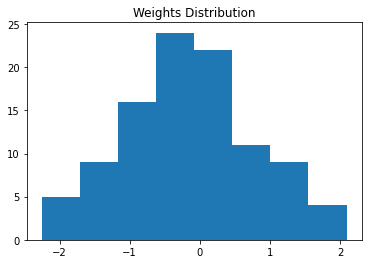

In [22]:
def plot_weight_distribution(weights):
  weights = torch.flatten(weights).to('cpu')
  plt.hist(weights, bins='fd')
  plt.title("Weights Distribution")
  plt.show()

plot_weight_distribution(weights)

In [ ]:
a = [1, 2, 3]
print(a[-2:])
print(a[-0:])

[2, 3]
[1, 2, 3]


In [ ]:
#@title Purely Online Implementation
thres = args['thres']
u_rest = args['u_rest']

mem = u_rest * torch.ones(nb_outputs, device=device, dtype=dtype)
syn = torch.zeros(nb_outputs, device=device, dtype=dtype)

epochs = 1


loss_rec = []
for i in tqdm(range(epochs)):

  m = 0
  mem_rec = []
  spk_rec = []

  eligibility_trace_record = torch.zeros((nb_inputs, nb_steps), device=device, dtype=dtype)
 # pre_trace_rec = torch.zeros((nb_inputs, nb_inputs, nb_steps), device=device, dtype=dtype)
  

  eligibility_rec = []
  pre_trace_rec = []
  error_rec = []

  last_presynaptic_traces = [torch.zeros(nb_inputs, device=device, dtype=dtype),
                             torch.zeros(nb_inputs, device=device, dtype=dtype)]
  last_eligibility_traces = [torch.zeros(nb_inputs, device=device, dtype=dtype),
                             torch.zeros(nb_inputs, device=device, dtype=dtype)] # not sure about the shape here, might have to recheck

  last_error_values = [torch.zeros(nb_inputs, device=device, dtype=dtype),
                       torch.zeros(nb_inputs, device=device, dtype=dtype)]

  reset = 0
  for t in range(nb_steps):

    out = spike_fn(mem, thres)

    spk_rec.append(out)
    mem_rec.append(mem)

    # refractory period = 5 ms = 50 timesteps of 0.1 ms each
    if t < 50:
      if 1 in spk_rec:
        reset = 1
      #  print("Reseting membrane potential to resting value")
    elif 1 in spk_rec[-50:]:
      reset = 1
    else:
      reset = 0

 #   weights = torch.flatten(weights)

    weighted_inp = torch.sum(input_trains[:, t] * weights.T)
    new_syn = alpha*syn + weighted_inp
    new_mem = (beta*mem + syn*(1 - beta) + u_rest*(1 - beta))*(1 - reset) + (reset * u_rest)

    mem = new_mem
    syn = new_syn
    
    # compute presynaptic traces
    presynaptic_traces = presynaptic_trace(last_presynaptic_traces[0],
                                           last_presynaptic_traces[1],
                                           input_trains[:, t], args)    
    last_presynaptic_traces = presynaptic_traces
    pre_trace_rec.append(presynaptic_traces[1])

    # evaluate hebbian coincidence
    h = mem - thres
    post = 1 / (1 + torch.abs(h))**2
    hebbian = post * presynaptic_traces[1]

    # eligibility trace
    synaptic_eligibility = eligibility_trace2(last_eligibility_traces[0],
                                              last_eligibility_traces[1],
                                              hebbian, args)
    last_eligibility_traces = synaptic_eligibility
    eligibility_rec.append(synaptic_eligibility[1])
  
    # error signal
    error = error_signal2(last_error_values[0], last_error_values[1],
                          out, target[t], args)
    last_error_values = error
    error_rec.append(error[1])

    # for minibatching weight updates in time
    m += error[1] * synaptic_eligibility[1]
 # weights += m

  # loss evaluation
  spk_rec = torch.stack(spk_rec, dim=0)
  loss = van_rossum_loss(spk_rec, target, args)
  print("Loss =", loss)
  loss_rec.append(loss)

  # stacking and flattening recordings
  spk_rec = torch.flatten(spk_rec)
  print("Spike train:", spk_rec)
  error_rec = torch.stack(error_rec, dim=0)
  eligibility_rec = torch.stack(eligibility_rec, dim=1)
  pre_trace_rec = torch.stack(pre_trace_rec, dim = 1)
 
  j = 5
  #plot_traces(eligibility_rec, pre_trace_rec, input_trains, j)
  e1 = eligibility_rec.to(cpu)
  p1 = pre_trace_rec.to(cpu)
  inp = input_trains.to(cpu)
  plot_traces(e1, p1, inp, j)

 # mem_cpu = mem_rec.to(cpu)
  spk_cpu = spk_rec.to(cpu)
  error_rec_cpu = error_rec.to(cpu)
  target_cpu = target.to(cpu)
  plot_neuron_dynamics(mem_rec, spk_cpu, error_rec_cpu, target_cpu)

#print(loss_rec)
#plt.plot(loss_rec)
    

  0%|          | 0/1 [00:03<?, ?it/s]

Loss = tensor([2.5892e-11])
Spike train: tensor([0., 0., 0.,  ..., 0., 0., 0.])


NameError: ignored

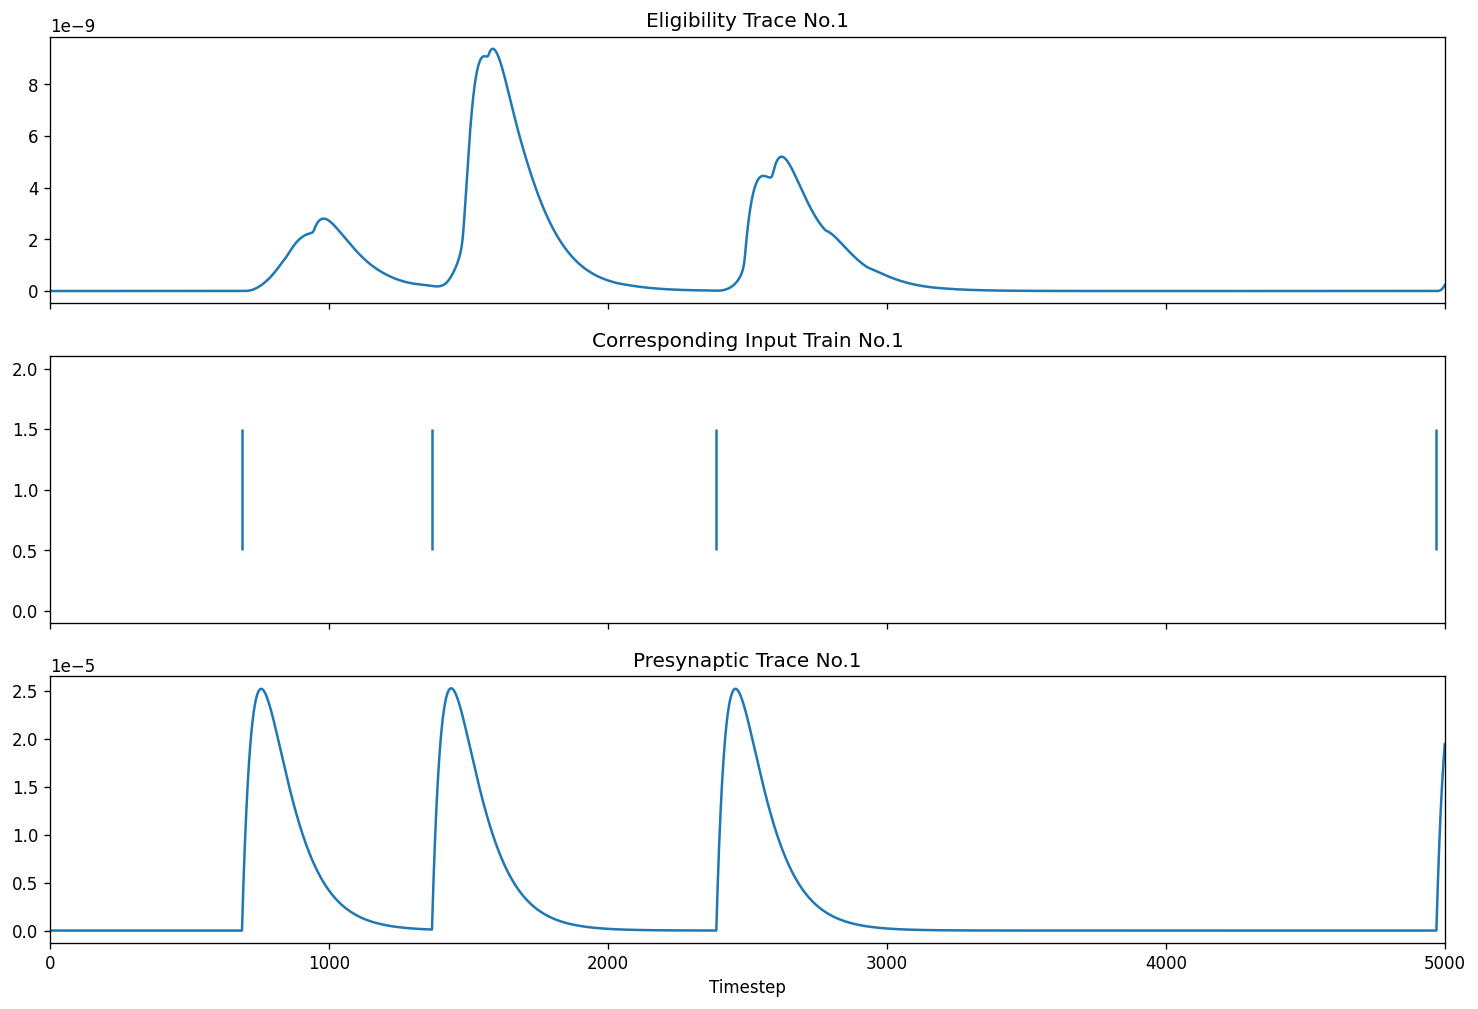

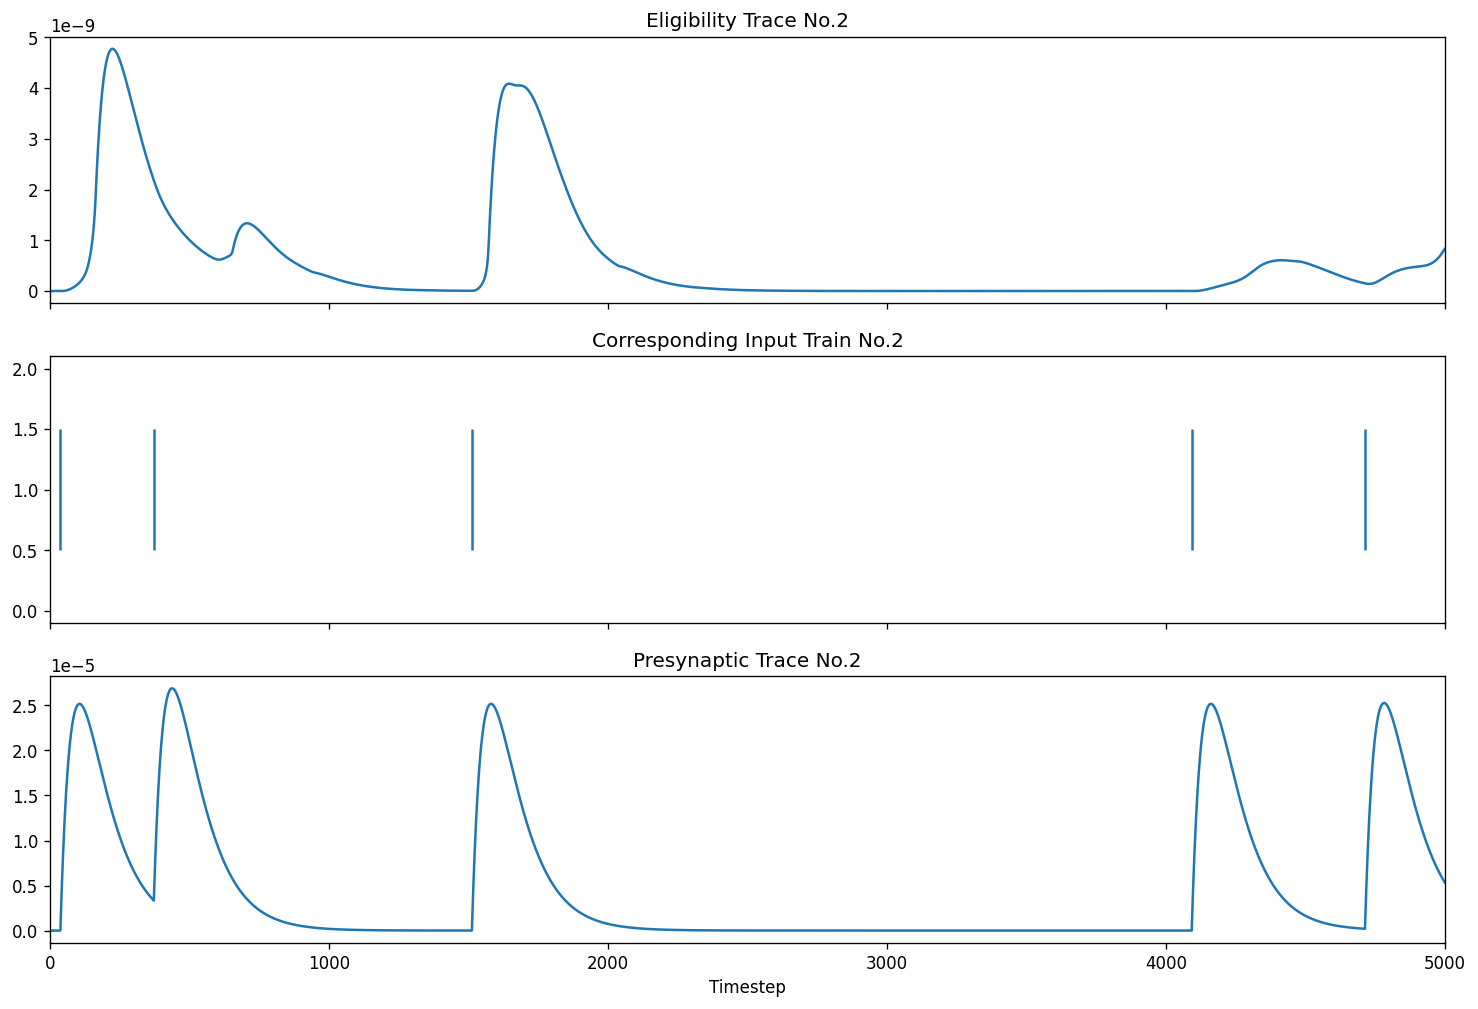

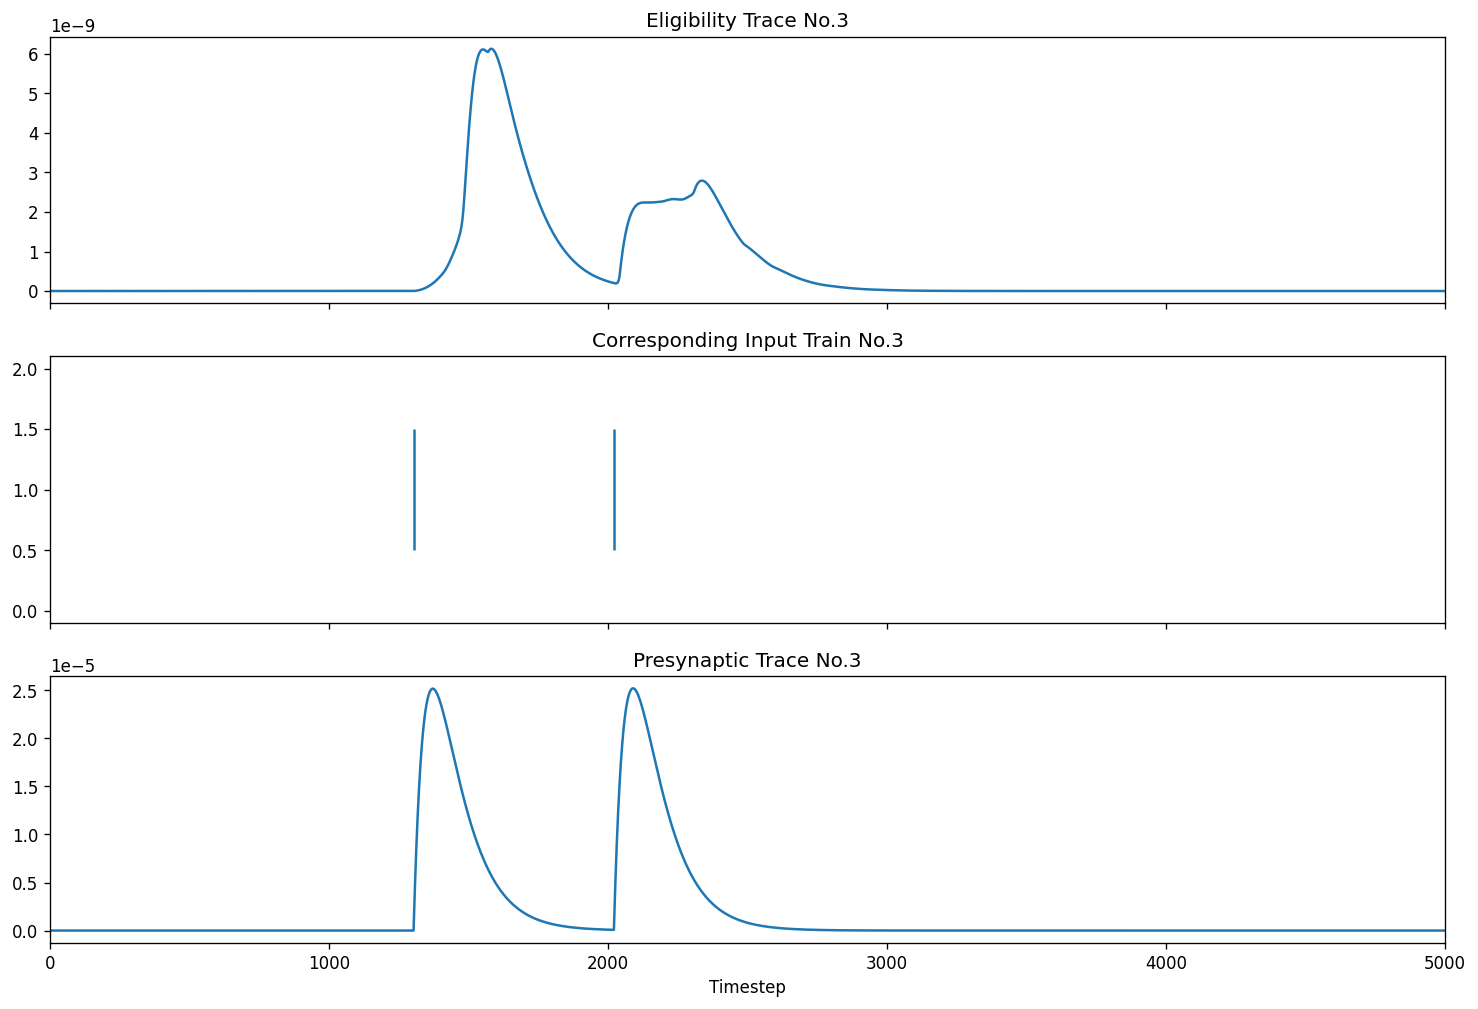

In [ ]:
#plot_traces(eligibility_rec, pre_trace_rec, input_trains, j)
plot_traces(eligibility_rec, pre_trace_rec, input_trains, 1)
plot_traces(eligibility_rec, pre_trace_rec, input_trains, 2)
plot_traces(eligibility_rec, pre_trace_rec, input_trains, 3)

#### Raster Plot

In [23]:
def plot_single_train(spike_train, nb_steps, timestep_size, idx=0):

  positions = np.arange(0, nb_steps)
  spike_positions = positions[spike_train == 1]
 # print(spike_positions)
  plt.eventplot(spike_positions, lineoffsets=idx)
  plt.xlim(0, nb_steps)
  #plt.show()

def plot_trains(spike_trains, title='Spike Trains'):
  plt.figure(dpi = 100)
  for i in range(len(spike_trains)):
    plot_single_train(spike_trains[i], nb_steps, timestep_size, idx=i)
  plt.title(title)
  plt.xlabel('Timestep')
  plt.ylabel('Spike Train No.')
  plt.show()


def plot_traces(eligiblity_rec, pre_synaptic_rec, input_trains, idx):
    
  j = idx

  fig, axs = plt.subplots(3, sharex=True, figsize=(15,10), dpi=120)

  axs[0].plot(eligibility_rec[j, 0, :])
  axs[0].set_title("Eligibility Trace No." + str(j))
 
  positions = np.arange(0, nb_steps)
  spike_positions = positions[input_trains[j] == 1]
  axs[1].eventplot(spike_positions)
  axs[1].set_title("Corresponding Input Train No." + str(j))
  axs[1].set_xlim([0, nb_steps])

  axs[2].plot(pre_trace_rec[j])
  axs[2].set_title("Presynaptic Trace No." + str(j))

  for ax in axs.flat:
    ax.set(xlabel = "Timestep")
    # Hide x labels and tick labels for top plots and y ticks for right plots:
    ax.label_outer()

 # fig.show()

def plot_neuron_dynamics(mem_rec, spk_rec, error_rec, target):

  fig, axs = plt.subplots(4, sharex=True, figsize=(15, 10), dpi=120)

  ## Plot the target spike train
  positions = np.arange(0, nb_steps)
  spike_positions = positions[target == 1]
  axs[0].eventplot(spike_positions)
  axs[0].set_title("Target Spike Train")
  axs[0].set_xlim([0, nb_steps])

  ## Plot error signal
  axs[1].plot(error_rec)
  axs[1].set_title("Error Signal")

  ## Plot output spike train
  positions = np.arange(0, nb_steps)
  spike_positions = positions[spk_rec == 1]
  axs[2].eventplot(spike_positions)
  axs[2].set_title("Output Spike Train")
  axs[2].set_xlim([0, nb_steps])

  ## Plot membrane potential
  axs[3].plot(mem_rec)
  axs[3].set_title("Membrane Potential")
  axs[3].set_ylabel("Potential (in mV)")

  for ax in axs.flat:
    ax.set(xlabel = "Timestep")
    # Hide x labels and tick labels for top plots and y ticks for right plots:
    ax.label_outer()

 # fig.show()

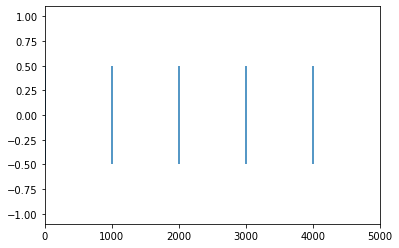

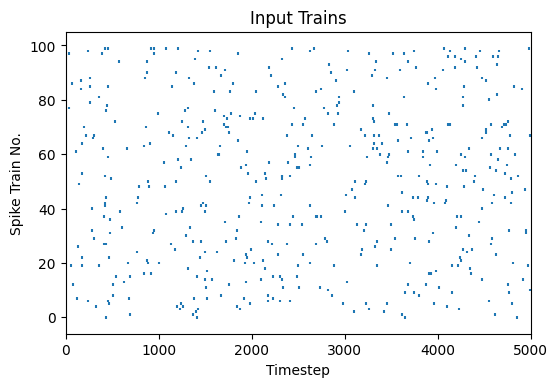

In [24]:
plot_single_train(target, nb_steps, timestep_size)
plt.show()

plot_trains(input_trains, title = "Input Trains")

In [25]:
def run_single_neuron(input_trains, weights, target, args):
  """
  Run a single LIF neuron as specificed by Zenke Ganguli for one epoch
  Inputs:
    input_trains
    weights
    target - desired spike train
    args['thres']
    args['u_rest']
  Returns:
    mem_rec, spk_rec, eligibility_rec, presynaptic_traces, error_signal

  """
  thres = args['thres']
  u_rest = args['u_rest']
  nb_steps = args['nb_steps']

  # initialize membrane and synaptic current 
  mem = u_rest * torch.ones(nb_outputs, device=device, dtype=dtype)
  syn = torch.zeros(nb_outputs, device=device, dtype=dtype)

  # lists to store traces and neuron variables
  mem_rec = []
  spk_rec = []
  eligibility_rec = []
  pre_trace_rec = []
  error_rec = []

  reset = 0

  for t in range(nb_steps):

    out = spike_fn(mem, thres)

    spk_rec.append(out)
    mem_rec.append(mem)

    # refractory period = 5 ms = 50 timesteps of 0.1 ms each
    if t < 50:
      if 1 in spk_rec:
        reset = 1
     #   print("Reseting membrane potential to resting value")
    elif 1 in spk_rec[-50:]:
      reset = 1
    else:
      reset = 0

    # LIF membrane potential update
    weighted_inp = torch.sum(input_trains[:, t] * weights.T)
    new_syn = alpha*syn + weighted_inp
    new_mem = (beta*mem + syn*(1 - beta) + u_rest*(1 - beta))*(1 - reset) + (reset * u_rest)

    mem = new_mem
    syn = new_syn
  # end of simulation loop
  
  mem_rec = torch.stack(mem_rec, dim=0)
  spk_rec = torch.stack(spk_rec, dim=0)
  spk_rec = torch.flatten(spk_rec) # stack as a 1-D array for easy difference with target train for error signal evaluation
  # compute presynaptic traces of shape: (nb_inputs, timesteps) 
  presynaptic_traces = new_presynaptic_trace(input_trains, args) 

  # evaluate hebbian coincidence
  h = mem_rec.T - thres  # shape: (nb_outputs, timesteps)
  post = 1 / (1 + torch.abs(h))**2 # shape: (nb_outputs, timesteps) 
  A = torch.unsqueeze(presynaptic_traces, 1)
  B = torch.unsqueeze(post, 0)
  hebbian = A * B # AB.T shape: (nb_inputs, nb_outputs, nb_timesteps)

  # eligibility trace
  eligibility = new_eligibility_trace(hebbian, args)
  
  # error signal
  error = new_error_signal(spk_rec, target, args)

  return mem_rec, spk_rec, error, eligibility, presynaptic_traces
  

In [26]:
#@title Running better neuron
num_epochs = 1

for i in range(num_epochs):
  mem_rec, spk_rec, error_rec, eligibility_rec, pre_trace_rec = run_single_neuron(input_trains, weights,
                                                                                  target, args)
  loss = new_van_rossum_loss(spk_rec, target, args)
  print("Loss = ", loss)
   

Loss =  tensor(166.6909)


In [27]:
print(eligibility_rec)

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.1107e-04,
          9.1815e-04, 9.2515e-04]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.4678e-04,
          6.4356e-04, 6.4036e-04]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.8994e-08,
          2.8729e-08, 2.8466e-08]],

        ...,

        [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.7474e-07,
          2.7226e-07, 2.6981e-07]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0205e-03,
          1.0155e-03, 1.0105e-03]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 7.7487e-05,
          7.8087e-05, 7.8845e-05]]])


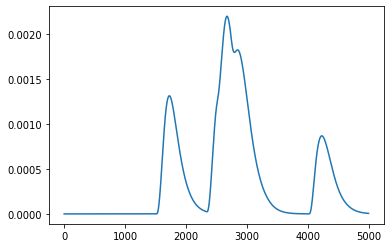

In [28]:
plt.plot(eligibility_rec[11, 0, :])

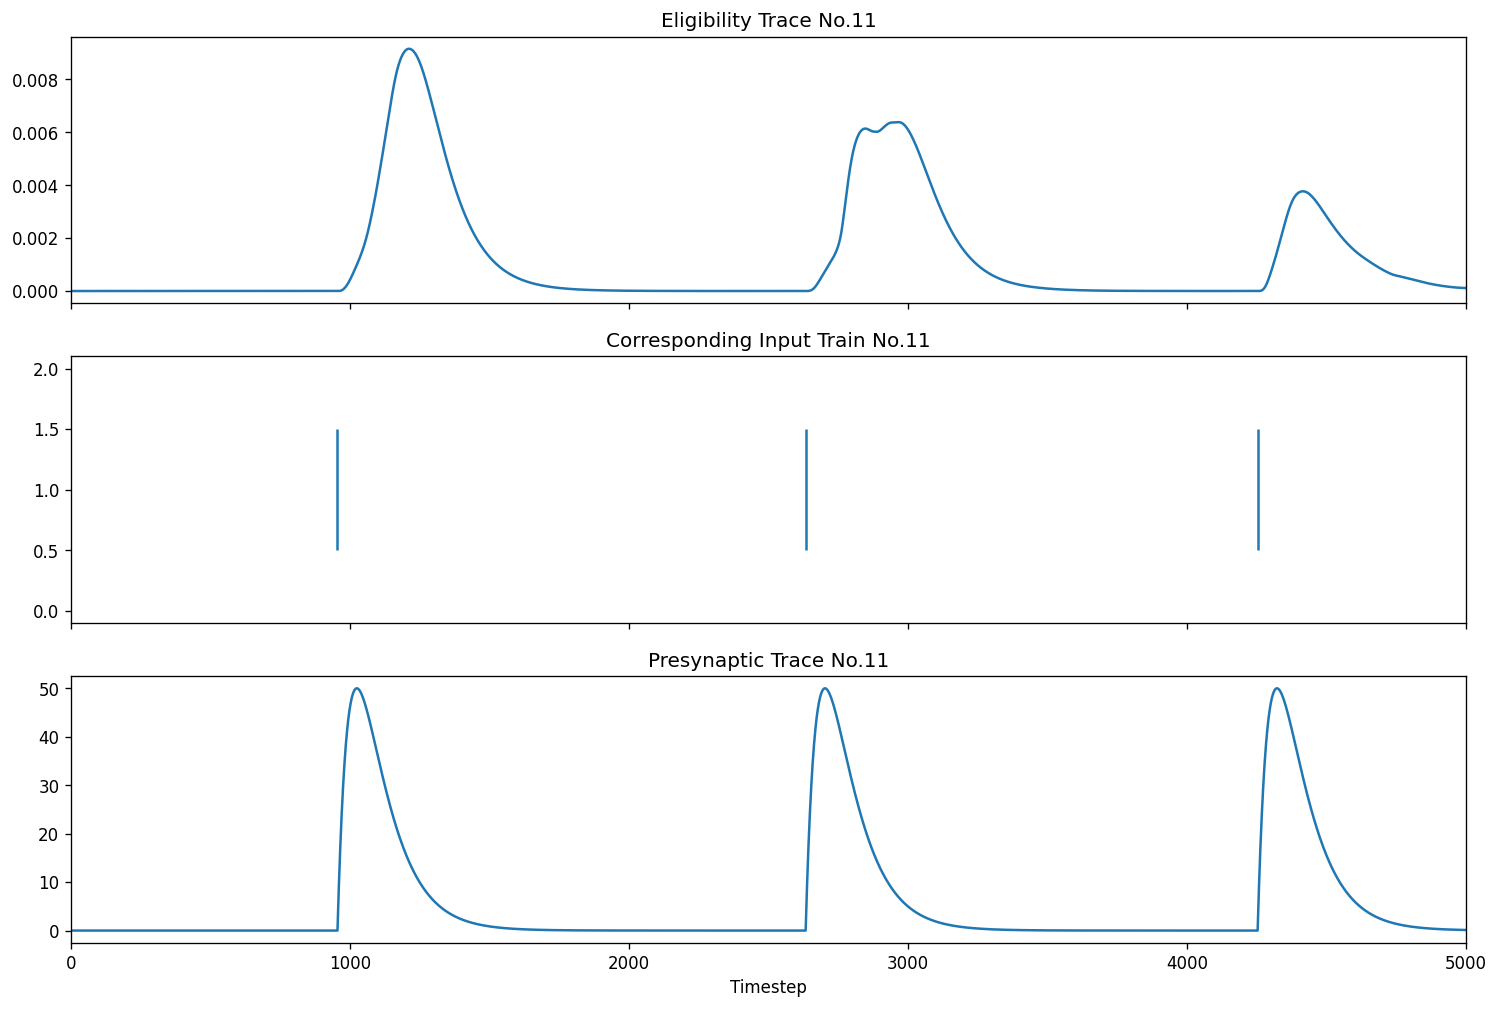

In [ ]:
plot_traces(eligibility_rec, pre_trace_rec, input_trains, 11)

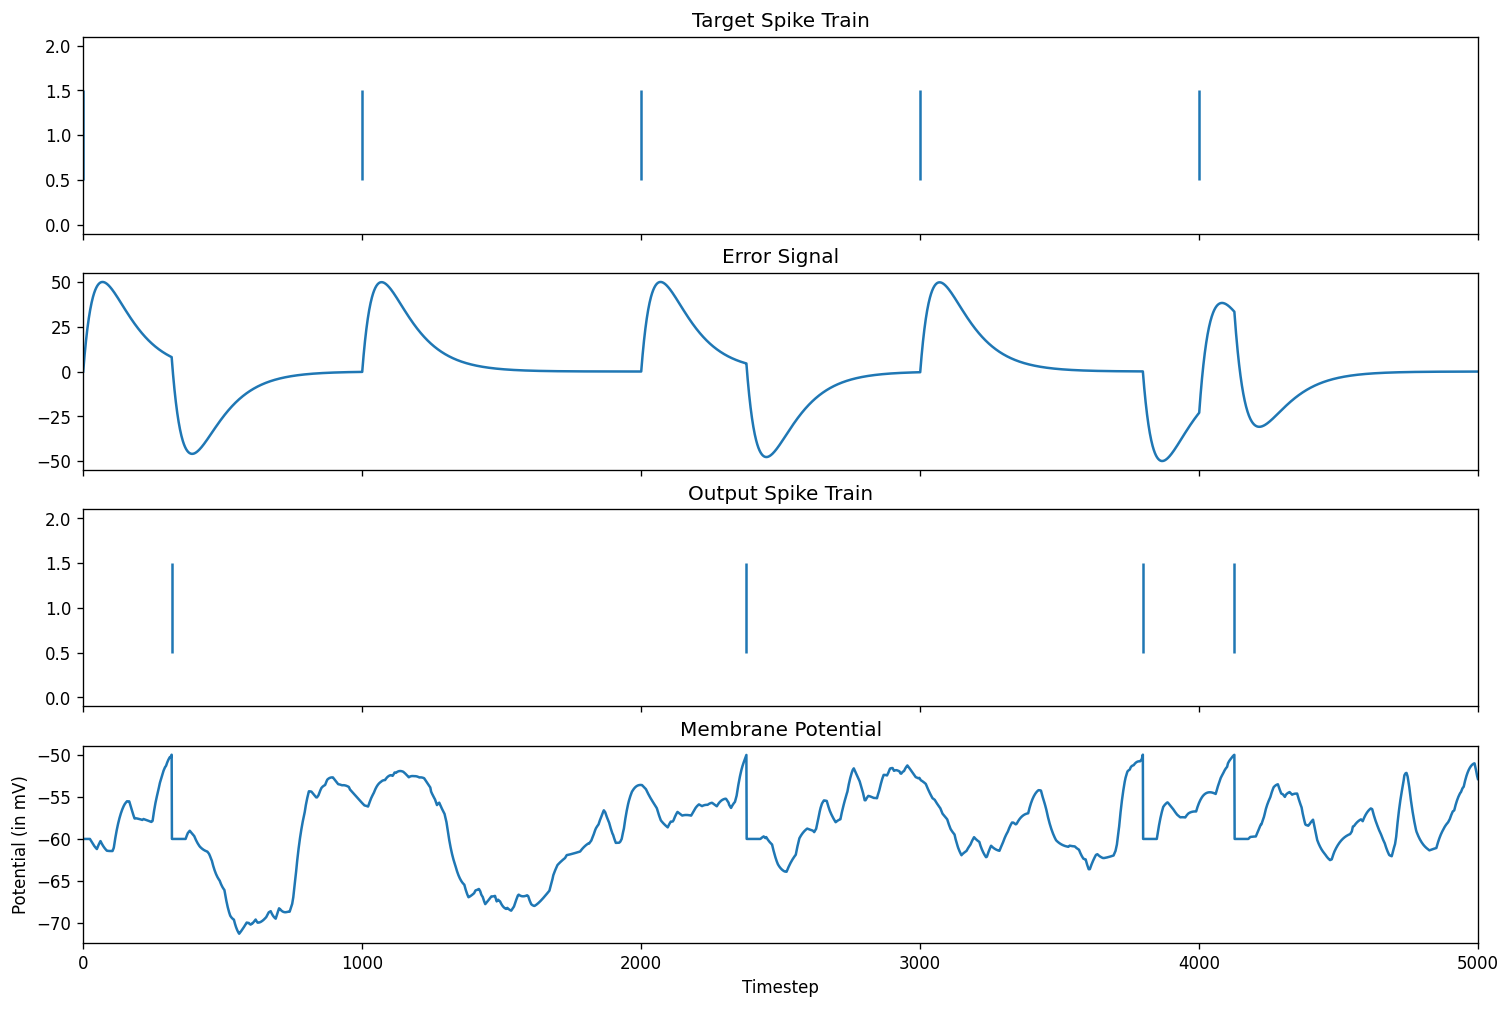

In [ ]:
plot_neuron_dynamics(mem_rec, spk_rec, error_rec, target)

Weight initialization done
<class 'torch.Tensor'>


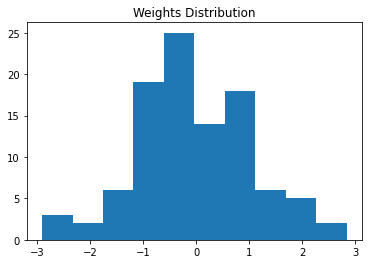

  0%|          | 0/500 [00:00<?, ?it/s]


 Iteration no: 1


  0%|          | 1/500 [00:04<38:19,  4.61s/it]


 Loss = tensor(166.6909)
Median Learning Rate: tensor(0.0081)
Avg. Learning Rate: tensor(0.0362)

 Iteration no: 2


  0%|          | 2/500 [00:09<37:31,  4.52s/it]


 Loss = tensor(166.6909)
Median Learning Rate: tensor(0.0073)
Avg. Learning Rate: tensor(0.0323)

 Iteration no: 3


  1%|          | 3/500 [00:13<37:12,  4.49s/it]


 Loss = tensor(166.6909)
Median Learning Rate: tensor(0.0065)
Avg. Learning Rate: tensor(0.0286)

 Iteration no: 4


  1%|          | 4/500 [00:18<37:06,  4.49s/it]


 Loss = tensor(166.6909)
Median Learning Rate: tensor(0.0057)
Avg. Learning Rate: tensor(0.0251)

 Iteration no: 5


  1%|          | 5/500 [00:22<37:10,  4.51s/it]


 Loss = tensor(166.6909)
Median Learning Rate: tensor(0.0050)
Avg. Learning Rate: tensor(0.0218)

 Iteration no: 6


  1%|          | 6/500 [00:27<37:07,  4.51s/it]


 Loss = tensor(166.6909)
Median Learning Rate: tensor(0.0044)
Avg. Learning Rate: tensor(0.0187)

 Iteration no: 7


  1%|▏         | 7/500 [00:31<36:59,  4.50s/it]


 Loss = tensor(166.6909)
Median Learning Rate: tensor(0.0037)
Avg. Learning Rate: tensor(0.0158)

 Iteration no: 8


  2%|▏         | 8/500 [00:36<36:54,  4.50s/it]


 Loss = tensor(166.6909)
Median Learning Rate: tensor(0.0031)
Avg. Learning Rate: tensor(0.0132)

 Iteration no: 9


  2%|▏         | 9/500 [00:40<36:58,  4.52s/it]


 Loss = tensor(166.6909)
Median Learning Rate: tensor(0.0025)
Avg. Learning Rate: tensor(0.0108)

 Iteration no: 10


  2%|▏         | 10/500 [00:45<37:01,  4.53s/it]


 Loss = tensor(166.6909)
Median Learning Rate: tensor(0.0020)
Avg. Learning Rate: tensor(0.0086)

 Iteration no: 11


  2%|▏         | 11/500 [00:49<36:49,  4.52s/it]


 Loss = tensor(166.6909)
Median Learning Rate: tensor(0.0016)
Avg. Learning Rate: tensor(0.0065)

 Iteration no: 12


  2%|▏         | 12/500 [00:54<36:38,  4.51s/it]


 Loss = tensor(196.6368)
Median Learning Rate: tensor(0.0008)
Avg. Learning Rate: tensor(0.0018)

 Iteration no: 13


  3%|▎         | 13/500 [00:58<36:30,  4.50s/it]


 Loss = tensor(166.6909)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 14


  3%|▎         | 14/500 [01:03<36:18,  4.48s/it]


 Loss = tensor(227.9886)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 15


  3%|▎         | 15/500 [01:07<36:11,  4.48s/it]


 Loss = tensor(166.6909)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 16


  3%|▎         | 16/500 [01:11<36:01,  4.47s/it]


 Loss = tensor(222.5746)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 17


  3%|▎         | 17/500 [01:16<36:02,  4.48s/it]


 Loss = tensor(133.3779)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 18


  4%|▎         | 18/500 [01:21<36:45,  4.57s/it]


 Loss = tensor(202.9693)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 19


  4%|▍         | 19/500 [01:25<36:31,  4.56s/it]


 Loss = tensor(115.1897)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 20


  4%|▍         | 20/500 [01:30<36:12,  4.53s/it]


 Loss = tensor(145.9324)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 21


  4%|▍         | 21/500 [01:34<35:53,  4.50s/it]


 Loss = tensor(114.0015)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 22


  4%|▍         | 22/500 [01:39<35:39,  4.48s/it]


 Loss = tensor(198.2053)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 23


  5%|▍         | 23/500 [01:43<35:33,  4.47s/it]


 Loss = tensor(146.6908)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 24


  5%|▍         | 24/500 [01:48<35:33,  4.48s/it]


 Loss = tensor(87.8600)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 25


  5%|▌         | 25/500 [01:52<35:21,  4.47s/it]


 Loss = tensor(86.9955)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 26


  5%|▌         | 26/500 [01:56<35:20,  4.47s/it]


 Loss = tensor(116.0274)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 27


  5%|▌         | 27/500 [02:01<35:09,  4.46s/it]


 Loss = tensor(84.7643)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 28


  6%|▌         | 28/500 [02:05<35:10,  4.47s/it]


 Loss = tensor(83.9484)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 29


  6%|▌         | 29/500 [02:10<35:20,  4.50s/it]


 Loss = tensor(83.4015)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 30


  6%|▌         | 30/500 [02:14<35:16,  4.50s/it]


 Loss = tensor(83.1343)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 31


  6%|▌         | 31/500 [02:19<35:27,  4.54s/it]


 Loss = tensor(115.7238)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 32


  6%|▋         | 32/500 [02:24<35:25,  4.54s/it]


 Loss = tensor(82.6165)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 33


  7%|▋         | 33/500 [02:28<35:20,  4.54s/it]


 Loss = tensor(82.3298)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 34


  7%|▋         | 34/500 [02:33<35:02,  4.51s/it]


 Loss = tensor(81.8179)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 35


  7%|▋         | 35/500 [02:37<34:39,  4.47s/it]


 Loss = tensor(112.0261)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 36


  7%|▋         | 36/500 [02:41<34:27,  4.46s/it]


 Loss = tensor(81.0360)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 37


  7%|▋         | 37/500 [02:46<34:23,  4.46s/it]


 Loss = tensor(80.7926)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 38


  8%|▊         | 38/500 [02:51<36:11,  4.70s/it]


 Loss = tensor(176.6527)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 39


  8%|▊         | 39/500 [02:56<35:57,  4.68s/it]


 Loss = tensor(107.8203)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 40


  8%|▊         | 40/500 [03:00<35:34,  4.64s/it]


 Loss = tensor(81.7961)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 41


  8%|▊         | 41/500 [03:05<35:10,  4.60s/it]


 Loss = tensor(81.8792)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 42


  8%|▊         | 42/500 [03:12<39:54,  5.23s/it]


 Loss = tensor(226.7892)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 43


  9%|▊         | 43/500 [03:16<38:17,  5.03s/it]


 Loss = tensor(79.5394)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 44


  9%|▉         | 44/500 [03:21<37:11,  4.89s/it]


 Loss = tensor(79.6337)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 45


  9%|▉         | 45/500 [03:25<36:25,  4.80s/it]


 Loss = tensor(124.9350)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 46


  9%|▉         | 46/500 [03:30<35:47,  4.73s/it]


 Loss = tensor(139.6604)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 47


  9%|▉         | 47/500 [03:34<35:20,  4.68s/it]


 Loss = tensor(77.1237)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 48


 10%|▉         | 48/500 [03:39<35:03,  4.65s/it]


 Loss = tensor(77.3463)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 49


 10%|▉         | 49/500 [03:44<34:44,  4.62s/it]


 Loss = tensor(235.9863)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 50


 10%|█         | 50/500 [03:48<34:29,  4.60s/it]


 Loss = tensor(74.2210)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 51


 10%|█         | 51/500 [03:53<34:26,  4.60s/it]


 Loss = tensor(78.1102)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 52


 10%|█         | 52/500 [03:57<34:14,  4.59s/it]


 Loss = tensor(76.4921)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 53


 11%|█         | 53/500 [04:02<34:04,  4.57s/it]


 Loss = tensor(75.0650)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 54


 11%|█         | 54/500 [04:06<33:51,  4.55s/it]


 Loss = tensor(72.0341)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 55


 11%|█         | 55/500 [04:11<33:48,  4.56s/it]


 Loss = tensor(101.4626)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 56


 11%|█         | 56/500 [04:15<33:48,  4.57s/it]


 Loss = tensor(112.0350)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 57


 11%|█▏        | 57/500 [04:20<33:45,  4.57s/it]


 Loss = tensor(78.8966)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 58


 12%|█▏        | 58/500 [04:25<33:41,  4.57s/it]


 Loss = tensor(77.4726)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 59


 12%|█▏        | 59/500 [04:29<33:31,  4.56s/it]


 Loss = tensor(51.9364)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 60


 12%|█▏        | 60/500 [04:34<33:28,  4.56s/it]


 Loss = tensor(50.3128)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 61


 12%|█▏        | 61/500 [04:38<33:20,  4.56s/it]


 Loss = tensor(75.6554)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 62


 12%|█▏        | 62/500 [04:43<33:12,  4.55s/it]


 Loss = tensor(78.2406)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 63


 13%|█▎        | 63/500 [04:47<33:14,  4.56s/it]


 Loss = tensor(76.8189)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 64


 13%|█▎        | 64/500 [04:52<33:14,  4.58s/it]


 Loss = tensor(74.4803)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 65


 13%|█▎        | 65/500 [04:57<33:16,  4.59s/it]


 Loss = tensor(51.8351)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 66


 13%|█▎        | 66/500 [05:01<33:05,  4.58s/it]


 Loss = tensor(50.8371)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 67


 13%|█▎        | 67/500 [05:06<33:17,  4.61s/it]


 Loss = tensor(49.8037)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 68


 14%|█▎        | 68/500 [05:10<33:06,  4.60s/it]


 Loss = tensor(48.8603)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 69


 14%|█▍        | 69/500 [05:15<33:01,  4.60s/it]


 Loss = tensor(73.9484)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 70


 14%|█▍        | 70/500 [05:20<32:54,  4.59s/it]


 Loss = tensor(52.4486)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0002)

 Iteration no: 71


 14%|█▍        | 71/500 [05:24<32:48,  4.59s/it]


 Loss = tensor(51.7089)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 72


 14%|█▍        | 72/500 [05:29<32:44,  4.59s/it]


 Loss = tensor(50.8704)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 73


 15%|█▍        | 73/500 [05:33<32:41,  4.59s/it]


 Loss = tensor(49.8957)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 74


 15%|█▍        | 74/500 [05:38<32:37,  4.59s/it]


 Loss = tensor(49.0199)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 75


 15%|█▌        | 75/500 [05:43<32:30,  4.59s/it]


 Loss = tensor(48.0905)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 76


 15%|█▌        | 76/500 [05:47<32:24,  4.59s/it]


 Loss = tensor(47.2078)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 77


 15%|█▌        | 77/500 [05:52<32:27,  4.60s/it]


 Loss = tensor(45.2292)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 78


 16%|█▌        | 78/500 [05:56<32:19,  4.59s/it]


 Loss = tensor(130.6106)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 79


 16%|█▌        | 79/500 [06:01<32:10,  4.59s/it]


 Loss = tensor(84.0957)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 80


 16%|█▌        | 80/500 [06:05<31:58,  4.57s/it]


 Loss = tensor(51.6792)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 81


 16%|█▌        | 81/500 [06:10<31:48,  4.55s/it]


 Loss = tensor(50.9700)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 82


 16%|█▋        | 82/500 [06:15<31:41,  4.55s/it]


 Loss = tensor(50.3596)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 83


 17%|█▋        | 83/500 [06:19<31:33,  4.54s/it]


 Loss = tensor(49.6540)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 84


 17%|█▋        | 84/500 [06:24<31:28,  4.54s/it]


 Loss = tensor(48.7839)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 85


 17%|█▋        | 85/500 [06:28<31:22,  4.54s/it]


 Loss = tensor(47.8956)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 86


 17%|█▋        | 86/500 [06:33<31:22,  4.55s/it]


 Loss = tensor(104.1437)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 87


 17%|█▋        | 87/500 [06:37<31:09,  4.53s/it]


 Loss = tensor(50.5429)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 88


 18%|█▊        | 88/500 [06:42<31:01,  4.52s/it]


 Loss = tensor(49.9698)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 89


 18%|█▊        | 89/500 [06:46<30:53,  4.51s/it]


 Loss = tensor(49.5887)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 90


 18%|█▊        | 90/500 [06:51<30:40,  4.49s/it]


 Loss = tensor(48.9907)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 91


 18%|█▊        | 91/500 [06:55<30:34,  4.48s/it]


 Loss = tensor(48.1360)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 92


 18%|█▊        | 92/500 [07:00<30:32,  4.49s/it]


 Loss = tensor(47.4962)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 93


 19%|█▊        | 93/500 [07:04<30:31,  4.50s/it]


 Loss = tensor(46.6198)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 94


 19%|█▉        | 94/500 [07:09<30:28,  4.50s/it]


 Loss = tensor(45.1826)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 95


 19%|█▉        | 95/500 [07:13<30:28,  4.52s/it]


 Loss = tensor(71.8261)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 96


 19%|█▉        | 96/500 [07:18<30:33,  4.54s/it]


 Loss = tensor(49.7020)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 97


 19%|█▉        | 97/500 [07:22<30:28,  4.54s/it]


 Loss = tensor(49.1092)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 98


 20%|█▉        | 98/500 [07:27<30:21,  4.53s/it]


 Loss = tensor(48.4547)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 99


 20%|█▉        | 99/500 [07:31<30:05,  4.50s/it]


 Loss = tensor(47.6307)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 100


 20%|██        | 100/500 [07:36<30:07,  4.52s/it]


 Loss = tensor(75.8668)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 101


 20%|██        | 101/500 [07:40<29:58,  4.51s/it]


 Loss = tensor(51.2519)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 102


 20%|██        | 102/500 [07:45<29:44,  4.48s/it]


 Loss = tensor(50.6313)
Median Learning Rate: tensor(0.0002)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 103


 21%|██        | 103/500 [07:49<29:44,  4.49s/it]


 Loss = tensor(49.9332)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 104


 21%|██        | 104/500 [07:54<29:37,  4.49s/it]


 Loss = tensor(49.6222)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 105


 21%|██        | 105/500 [07:58<29:40,  4.51s/it]


 Loss = tensor(49.0213)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 106


 21%|██        | 106/500 [08:03<29:38,  4.51s/it]


 Loss = tensor(48.0544)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 107


 21%|██▏       | 107/500 [08:07<29:34,  4.51s/it]


 Loss = tensor(104.4236)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 108


 22%|██▏       | 108/500 [08:12<29:15,  4.48s/it]


 Loss = tensor(50.7901)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 109


 22%|██▏       | 109/500 [08:16<29:17,  4.49s/it]


 Loss = tensor(50.1805)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 110


 22%|██▏       | 110/500 [08:21<29:10,  4.49s/it]


 Loss = tensor(49.8015)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 111


 22%|██▏       | 111/500 [08:25<29:06,  4.49s/it]


 Loss = tensor(49.1993)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 112


 22%|██▏       | 112/500 [08:30<29:06,  4.50s/it]


 Loss = tensor(48.8924)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 113


 23%|██▎       | 113/500 [08:34<28:49,  4.47s/it]


 Loss = tensor(48.3048)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 114


 23%|██▎       | 114/500 [08:38<28:34,  4.44s/it]


 Loss = tensor(47.9469)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 115


 23%|██▎       | 115/500 [08:43<28:27,  4.43s/it]


 Loss = tensor(47.3613)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 116


 23%|██▎       | 116/500 [08:47<28:16,  4.42s/it]


 Loss = tensor(46.4891)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 117


 23%|██▎       | 117/500 [08:52<28:03,  4.40s/it]


 Loss = tensor(45.6295)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 118


 24%|██▎       | 118/500 [08:56<28:03,  4.41s/it]


 Loss = tensor(102.6934)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 119


 24%|██▍       | 119/500 [09:00<27:54,  4.39s/it]


 Loss = tensor(81.4223)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 120


 24%|██▍       | 120/500 [09:05<27:43,  4.38s/it]


 Loss = tensor(75.4872)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 121


 24%|██▍       | 121/500 [09:09<27:37,  4.37s/it]


 Loss = tensor(50.3966)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 122


 24%|██▍       | 122/500 [09:13<27:20,  4.34s/it]


 Loss = tensor(50.0873)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 123


 25%|██▍       | 123/500 [09:18<27:25,  4.36s/it]


 Loss = tensor(49.4815)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 124


 25%|██▍       | 124/500 [09:22<27:35,  4.40s/it]


 Loss = tensor(49.1209)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 125


 25%|██▌       | 125/500 [09:27<27:39,  4.43s/it]


 Loss = tensor(48.8191)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 126


 25%|██▌       | 126/500 [09:31<27:39,  4.44s/it]


 Loss = tensor(48.2240)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 127


 25%|██▌       | 127/500 [09:36<27:36,  4.44s/it]


 Loss = tensor(47.9345)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 128


 26%|██▌       | 128/500 [09:40<27:32,  4.44s/it]


 Loss = tensor(47.0141)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 129


 26%|██▌       | 129/500 [09:45<27:22,  4.43s/it]


 Loss = tensor(46.4445)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 130


 26%|██▌       | 130/500 [09:49<27:24,  4.44s/it]


 Loss = tensor(103.8598)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 131


 26%|██▌       | 131/500 [09:53<27:23,  4.45s/it]


 Loss = tensor(49.7195)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 132


 26%|██▋       | 132/500 [09:58<27:21,  4.46s/it]


 Loss = tensor(49.1182)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 133


 27%|██▋       | 133/500 [10:02<27:24,  4.48s/it]


 Loss = tensor(49.1182)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 134


 27%|██▋       | 134/500 [10:07<27:24,  4.49s/it]


 Loss = tensor(48.4904)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 135


 27%|██▋       | 135/500 [10:11<27:19,  4.49s/it]


 Loss = tensor(48.1835)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 136


 27%|██▋       | 136/500 [10:16<27:16,  4.50s/it]


 Loss = tensor(47.5961)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 137


 27%|██▋       | 137/500 [10:20<27:11,  4.50s/it]


 Loss = tensor(47.2943)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 138


 28%|██▊       | 138/500 [10:25<27:07,  4.50s/it]


 Loss = tensor(46.7159)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 139


 28%|██▊       | 139/500 [10:29<26:59,  4.49s/it]


 Loss = tensor(46.1443)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 140


 28%|██▊       | 140/500 [10:34<26:56,  4.49s/it]


 Loss = tensor(45.8512)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 141


 28%|██▊       | 141/500 [10:38<26:51,  4.49s/it]


 Loss = tensor(45.2898)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 142


 28%|██▊       | 142/500 [10:43<26:45,  4.48s/it]


 Loss = tensor(44.4529)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 143


 29%|██▊       | 143/500 [10:47<26:51,  4.51s/it]


 Loss = tensor(43.6352)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 144


 29%|██▉       | 144/500 [10:52<26:44,  4.51s/it]


 Loss = tensor(101.3880)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 145


 29%|██▉       | 145/500 [10:56<26:40,  4.51s/it]


 Loss = tensor(46.9087)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 146


 29%|██▉       | 146/500 [11:01<26:33,  4.50s/it]


 Loss = tensor(46.0973)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 147


 29%|██▉       | 147/500 [11:06<26:31,  4.51s/it]


 Loss = tensor(106.8809)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 148


 30%|██▉       | 148/500 [11:10<26:27,  4.51s/it]


 Loss = tensor(80.1123)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 149


 30%|██▉       | 149/500 [11:15<26:20,  4.50s/it]


 Loss = tensor(47.0085)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 150


 30%|███       | 150/500 [11:19<26:16,  4.50s/it]


 Loss = tensor(46.7153)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 151


 30%|███       | 151/500 [11:24<26:11,  4.50s/it]


 Loss = tensor(46.1228)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 152


 30%|███       | 152/500 [11:28<26:07,  4.50s/it]


 Loss = tensor(45.8362)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 153


 31%|███       | 153/500 [11:33<26:12,  4.53s/it]


 Loss = tensor(45.5335)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 154


 31%|███       | 154/500 [11:37<26:06,  4.53s/it]


 Loss = tensor(44.6926)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 155


 31%|███       | 155/500 [11:42<26:00,  4.52s/it]


 Loss = tensor(72.4861)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 156


 31%|███       | 156/500 [11:46<25:54,  4.52s/it]


 Loss = tensor(49.2137)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0003)

 Iteration no: 157


 31%|███▏      | 157/500 [11:51<25:46,  4.51s/it]


 Loss = tensor(48.9307)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 158


 32%|███▏      | 158/500 [11:55<25:40,  4.50s/it]


 Loss = tensor(48.5749)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 159


 32%|███▏      | 159/500 [12:00<25:26,  4.48s/it]


 Loss = tensor(48.2956)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 160


 32%|███▏      | 160/500 [12:04<25:20,  4.47s/it]


 Loss = tensor(47.9864)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 161


 32%|███▏      | 161/500 [12:08<25:13,  4.47s/it]


 Loss = tensor(47.9864)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 162


 32%|███▏      | 162/500 [12:13<25:13,  4.48s/it]


 Loss = tensor(47.4484)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 163


 33%|███▎      | 163/500 [12:17<25:09,  4.48s/it]


 Loss = tensor(47.4484)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 164


 33%|███▎      | 164/500 [12:22<25:02,  4.47s/it]


 Loss = tensor(106.7049)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 165


 33%|███▎      | 165/500 [12:26<24:56,  4.47s/it]


 Loss = tensor(73.4542)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 166


 33%|███▎      | 166/500 [12:31<24:52,  4.47s/it]


 Loss = tensor(48.1862)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 167


 33%|███▎      | 167/500 [12:35<24:51,  4.48s/it]


 Loss = tensor(48.1862)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 168


 34%|███▎      | 168/500 [12:40<24:49,  4.49s/it]


 Loss = tensor(47.6166)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 169


 34%|███▍      | 169/500 [12:44<24:48,  4.50s/it]


 Loss = tensor(47.3266)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 170


 34%|███▍      | 170/500 [12:49<24:41,  4.49s/it]


 Loss = tensor(74.6664)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 171


 34%|███▍      | 171/500 [12:53<24:34,  4.48s/it]


 Loss = tensor(73.6313)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 172


 34%|███▍      | 172/500 [12:58<24:32,  4.49s/it]


 Loss = tensor(49.8037)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 173


 35%|███▍      | 173/500 [13:02<24:29,  4.49s/it]


 Loss = tensor(49.8037)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 174


 35%|███▍      | 174/500 [13:07<24:12,  4.45s/it]


 Loss = tensor(77.0111)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 175


 35%|███▌      | 175/500 [13:11<24:03,  4.44s/it]


 Loss = tensor(48.4504)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 176


 35%|███▌      | 176/500 [13:15<23:56,  4.43s/it]


 Loss = tensor(48.1722)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 177


 35%|███▌      | 177/500 [13:20<23:53,  4.44s/it]


 Loss = tensor(48.1722)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 178


 36%|███▌      | 178/500 [13:24<23:47,  4.43s/it]


 Loss = tensor(47.5839)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 179


 36%|███▌      | 179/500 [13:29<23:36,  4.41s/it]


 Loss = tensor(47.5839)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 180


 36%|███▌      | 180/500 [13:33<23:28,  4.40s/it]


 Loss = tensor(74.9149)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 181


 36%|███▌      | 181/500 [13:37<23:23,  4.40s/it]


 Loss = tensor(45.8239)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 182


 36%|███▋      | 182/500 [13:42<23:17,  4.39s/it]


 Loss = tensor(45.5484)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 183


 37%|███▋      | 183/500 [13:46<23:08,  4.38s/it]


 Loss = tensor(45.2552)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 184


 37%|███▋      | 184/500 [13:51<23:05,  4.39s/it]


 Loss = tensor(44.9654)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 185


 37%|███▋      | 185/500 [13:55<23:03,  4.39s/it]


 Loss = tensor(44.7006)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 186


 37%|███▋      | 186/500 [14:00<23:09,  4.43s/it]


 Loss = tensor(44.4212)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 187


 37%|███▋      | 187/500 [14:04<23:13,  4.45s/it]


 Loss = tensor(71.4093)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 188


 38%|███▊      | 188/500 [14:08<23:08,  4.45s/it]


 Loss = tensor(71.2758)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 189


 38%|███▊      | 189/500 [14:13<23:11,  4.48s/it]


 Loss = tensor(44.2350)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 190


 38%|███▊      | 190/500 [14:18<23:08,  4.48s/it]


 Loss = tensor(43.9798)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 191


 38%|███▊      | 191/500 [14:22<23:09,  4.50s/it]


 Loss = tensor(43.4431)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 192


 38%|███▊      | 192/500 [14:26<22:58,  4.48s/it]


 Loss = tensor(131.9304)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 193


 39%|███▊      | 193/500 [14:31<22:53,  4.47s/it]


 Loss = tensor(103.5173)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 194


 39%|███▉      | 194/500 [14:35<22:47,  4.47s/it]


 Loss = tensor(48.4505)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 195


 39%|███▉      | 195/500 [14:40<22:44,  4.47s/it]


 Loss = tensor(48.4505)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 196


 39%|███▉      | 196/500 [14:44<22:35,  4.46s/it]


 Loss = tensor(47.8595)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 197


 39%|███▉      | 197/500 [14:49<22:33,  4.47s/it]


 Loss = tensor(47.8595)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 198


 40%|███▉      | 198/500 [14:53<22:24,  4.45s/it]


 Loss = tensor(75.3801)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 199


 40%|███▉      | 199/500 [14:58<22:19,  4.45s/it]


 Loss = tensor(47.0539)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 200


 40%|████      | 200/500 [15:02<22:19,  4.47s/it]


 Loss = tensor(46.4266)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 201


 40%|████      | 201/500 [15:07<22:07,  4.44s/it]


 Loss = tensor(46.4266)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 202


 40%|████      | 202/500 [15:11<21:59,  4.43s/it]


 Loss = tensor(46.4002)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 203


 41%|████      | 203/500 [15:15<21:54,  4.43s/it]


 Loss = tensor(46.1071)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 204


 41%|████      | 204/500 [15:20<21:49,  4.42s/it]


 Loss = tensor(73.6378)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 205


 41%|████      | 205/500 [15:24<21:49,  4.44s/it]


 Loss = tensor(44.8110)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 206


 41%|████      | 206/500 [15:29<21:43,  4.43s/it]


 Loss = tensor(44.2322)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 207


 41%|████▏     | 207/500 [15:33<21:40,  4.44s/it]


 Loss = tensor(44.1804)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 208


 42%|████▏     | 208/500 [15:38<21:33,  4.43s/it]


 Loss = tensor(43.9048)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0004)

 Iteration no: 209


 42%|████▏     | 209/500 [15:42<21:30,  4.43s/it]


 Loss = tensor(43.6070)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 210


 42%|████▏     | 210/500 [15:46<21:28,  4.44s/it]


 Loss = tensor(70.6103)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 211


 42%|████▏     | 211/500 [15:51<21:25,  4.45s/it]


 Loss = tensor(70.0261)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 212


 42%|████▏     | 212/500 [15:55<21:19,  4.44s/it]


 Loss = tensor(43.7195)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 213


 43%|████▎     | 213/500 [16:00<21:14,  4.44s/it]


 Loss = tensor(43.7195)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 214


 43%|████▎     | 214/500 [16:04<21:13,  4.45s/it]


 Loss = tensor(43.1667)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 215


 43%|████▎     | 215/500 [16:09<21:08,  4.45s/it]


 Loss = tensor(100.4351)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 216


 43%|████▎     | 216/500 [16:13<21:09,  4.47s/it]


 Loss = tensor(46.1584)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 217


 43%|████▎     | 217/500 [16:18<21:06,  4.47s/it]


 Loss = tensor(45.8895)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 218


 44%|████▎     | 218/500 [16:22<21:01,  4.47s/it]


 Loss = tensor(45.8895)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 219


 44%|████▍     | 219/500 [16:27<20:58,  4.48s/it]


 Loss = tensor(73.1908)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 220


 44%|████▍     | 220/500 [16:31<20:47,  4.46s/it]


 Loss = tensor(72.2964)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 221


 44%|████▍     | 221/500 [16:35<20:40,  4.45s/it]


 Loss = tensor(46.3860)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 222


 44%|████▍     | 222/500 [16:40<20:38,  4.46s/it]


 Loss = tensor(46.1158)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 223


 45%|████▍     | 223/500 [16:44<20:36,  4.47s/it]


 Loss = tensor(46.1158)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 224


 45%|████▍     | 224/500 [16:49<20:30,  4.46s/it]


 Loss = tensor(73.6258)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 225


 45%|████▌     | 225/500 [16:53<20:23,  4.45s/it]


 Loss = tensor(72.0149)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 226


 45%|████▌     | 226/500 [16:58<20:23,  4.47s/it]


 Loss = tensor(46.0965)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 227


 45%|████▌     | 227/500 [17:02<20:23,  4.48s/it]


 Loss = tensor(46.1031)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 228


 46%|████▌     | 228/500 [17:07<20:19,  4.48s/it]


 Loss = tensor(46.0964)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 229


 46%|████▌     | 229/500 [17:11<20:15,  4.48s/it]


 Loss = tensor(45.5501)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 230


 46%|████▌     | 230/500 [17:16<20:06,  4.47s/it]


 Loss = tensor(45.5501)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 231


 46%|████▌     | 231/500 [17:20<19:55,  4.44s/it]


 Loss = tensor(105.1587)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 232


 46%|████▋     | 232/500 [17:25<19:46,  4.43s/it]


 Loss = tensor(73.1597)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 233


 47%|████▋     | 233/500 [17:29<19:41,  4.42s/it]


 Loss = tensor(44.6083)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 234


 47%|████▋     | 234/500 [17:33<19:41,  4.44s/it]


 Loss = tensor(44.5318)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 235


 47%|████▋     | 235/500 [17:38<19:37,  4.44s/it]


 Loss = tensor(44.1969)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 236


 47%|████▋     | 236/500 [17:42<19:34,  4.45s/it]


 Loss = tensor(44.1902)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 237


 47%|████▋     | 237/500 [17:47<19:26,  4.43s/it]


 Loss = tensor(71.5579)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 238


 48%|████▊     | 238/500 [17:51<19:25,  4.45s/it]


 Loss = tensor(70.3217)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 239


 48%|████▊     | 239/500 [17:56<19:23,  4.46s/it]


 Loss = tensor(79.7136)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 240


 48%|████▊     | 240/500 [18:00<19:16,  4.45s/it]


 Loss = tensor(77.1248)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 241


 48%|████▊     | 241/500 [18:05<19:10,  4.44s/it]


 Loss = tensor(73.3257)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 242


 48%|████▊     | 242/500 [18:09<19:04,  4.44s/it]


 Loss = tensor(74.5286)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 243


 49%|████▊     | 243/500 [18:13<18:59,  4.43s/it]


 Loss = tensor(48.6344)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 244


 49%|████▉     | 244/500 [18:18<18:54,  4.43s/it]


 Loss = tensor(76.5537)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 245


 49%|████▉     | 245/500 [18:22<18:49,  4.43s/it]


 Loss = tensor(47.5908)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 246


 49%|████▉     | 246/500 [18:27<18:43,  4.42s/it]


 Loss = tensor(47.5908)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 247


 49%|████▉     | 247/500 [18:31<18:38,  4.42s/it]


 Loss = tensor(47.2947)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 248


 50%|████▉     | 248/500 [18:36<18:39,  4.44s/it]


 Loss = tensor(47.3268)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 249


 50%|████▉     | 249/500 [18:40<18:35,  4.44s/it]


 Loss = tensor(47.3268)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 250


 50%|█████     | 250/500 [18:44<18:31,  4.45s/it]


 Loss = tensor(46.7793)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 251


 50%|█████     | 251/500 [18:49<18:28,  4.45s/it]


 Loss = tensor(106.9464)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 252


 50%|█████     | 252/500 [18:53<18:21,  4.44s/it]


 Loss = tensor(44.5239)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 253


 51%|█████     | 253/500 [18:58<18:19,  4.45s/it]


 Loss = tensor(43.9811)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 254


 51%|█████     | 254/500 [19:02<18:15,  4.45s/it]


 Loss = tensor(43.6739)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 255


 51%|█████     | 255/500 [19:07<18:08,  4.44s/it]


 Loss = tensor(43.1230)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 256


 51%|█████     | 256/500 [19:11<18:03,  4.44s/it]


 Loss = tensor(70.3182)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 257


 51%|█████▏    | 257/500 [19:16<18:02,  4.46s/it]


 Loss = tensor(45.5416)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 258


 52%|█████▏    | 258/500 [19:20<17:54,  4.44s/it]


 Loss = tensor(73.0678)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 259


 52%|█████▏    | 259/500 [19:24<17:52,  4.45s/it]


 Loss = tensor(44.2125)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 260


 52%|█████▏    | 260/500 [19:29<17:51,  4.46s/it]


 Loss = tensor(44.2058)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 261


 52%|█████▏    | 261/500 [19:33<17:49,  4.48s/it]


 Loss = tensor(43.8981)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 262


 52%|█████▏    | 262/500 [19:38<17:46,  4.48s/it]


 Loss = tensor(43.8785)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 263


 53%|█████▎    | 263/500 [19:42<17:39,  4.47s/it]


 Loss = tensor(70.9935)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 264


 53%|█████▎    | 264/500 [19:47<17:36,  4.48s/it]


 Loss = tensor(69.4494)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 265


 53%|█████▎    | 265/500 [19:51<17:32,  4.48s/it]


 Loss = tensor(44.0003)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 266


 53%|█████▎    | 266/500 [19:56<17:26,  4.47s/it]


 Loss = tensor(43.9614)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 267


 53%|█████▎    | 267/500 [20:00<17:24,  4.48s/it]


 Loss = tensor(43.6587)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 268


 54%|█████▎    | 268/500 [20:05<17:19,  4.48s/it]


 Loss = tensor(70.9820)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 269


 54%|█████▍    | 269/500 [20:09<17:12,  4.47s/it]


 Loss = tensor(103.0794)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 270


 54%|█████▍    | 270/500 [20:14<17:10,  4.48s/it]


 Loss = tensor(44.1768)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 271


 54%|█████▍    | 271/500 [20:18<17:05,  4.48s/it]


 Loss = tensor(43.9184)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 272


 54%|█████▍    | 272/500 [20:23<17:00,  4.48s/it]


 Loss = tensor(71.1463)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 273


 55%|█████▍    | 273/500 [20:27<16:55,  4.47s/it]


 Loss = tensor(46.0964)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 274


 55%|█████▍    | 274/500 [20:32<16:51,  4.47s/it]


 Loss = tensor(46.1030)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 275


 55%|█████▌    | 275/500 [20:36<16:46,  4.48s/it]


 Loss = tensor(73.7888)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 276


 55%|█████▌    | 276/500 [20:41<16:44,  4.49s/it]


 Loss = tensor(45.0141)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 277


 55%|█████▌    | 277/500 [20:45<16:38,  4.48s/it]


 Loss = tensor(44.6993)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 278


 56%|█████▌    | 278/500 [20:50<16:33,  4.48s/it]


 Loss = tensor(44.4239)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 279


 56%|█████▌    | 279/500 [20:54<16:27,  4.47s/it]


 Loss = tensor(44.1389)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0005)

 Iteration no: 280


 56%|█████▌    | 280/500 [20:58<16:20,  4.46s/it]


 Loss = tensor(44.1389)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 281


 56%|█████▌    | 281/500 [21:03<16:15,  4.46s/it]


 Loss = tensor(71.6676)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 282


 56%|█████▋    | 282/500 [21:07<16:07,  4.44s/it]


 Loss = tensor(70.6757)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 283


 57%|█████▋    | 283/500 [21:12<16:02,  4.44s/it]


 Loss = tensor(44.7270)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 284


 57%|█████▋    | 284/500 [21:16<15:58,  4.44s/it]


 Loss = tensor(44.4401)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 285


 57%|█████▋    | 285/500 [21:21<15:54,  4.44s/it]


 Loss = tensor(44.4334)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 286


 57%|█████▋    | 286/500 [21:25<15:52,  4.45s/it]


 Loss = tensor(44.1473)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 287


 57%|█████▋    | 287/500 [21:30<15:47,  4.45s/it]


 Loss = tensor(71.8949)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 288


 58%|█████▊    | 288/500 [21:34<15:42,  4.45s/it]


 Loss = tensor(69.8873)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 289


 58%|█████▊    | 289/500 [21:38<15:36,  4.44s/it]


 Loss = tensor(44.4886)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 290


 58%|█████▊    | 290/500 [21:43<15:33,  4.44s/it]


 Loss = tensor(44.4886)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 291


 58%|█████▊    | 291/500 [21:47<15:28,  4.44s/it]


 Loss = tensor(44.1886)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 292


 58%|█████▊    | 292/500 [21:52<15:22,  4.44s/it]


 Loss = tensor(44.1886)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 293


 59%|█████▊    | 293/500 [21:56<15:17,  4.43s/it]


 Loss = tensor(71.5904)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 294


 59%|█████▉    | 294/500 [22:01<15:15,  4.44s/it]


 Loss = tensor(42.1803)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 295


 59%|█████▉    | 295/500 [22:05<15:17,  4.48s/it]


 Loss = tensor(42.1481)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 296


 59%|█████▉    | 296/500 [22:10<15:11,  4.47s/it]


 Loss = tensor(42.1089)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 297


 59%|█████▉    | 297/500 [22:14<15:08,  4.47s/it]


 Loss = tensor(41.6090)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 298


 60%|█████▉    | 298/500 [22:19<15:03,  4.47s/it]


 Loss = tensor(41.5956)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 299


 60%|█████▉    | 299/500 [22:23<14:57,  4.46s/it]


 Loss = tensor(99.0650)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 300


 60%|██████    | 300/500 [22:27<14:48,  4.44s/it]


 Loss = tensor(44.7979)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 301


 60%|██████    | 301/500 [22:32<14:45,  4.45s/it]


 Loss = tensor(44.2530)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 302


 60%|██████    | 302/500 [22:36<14:39,  4.44s/it]


 Loss = tensor(71.2150)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 303


 61%|██████    | 303/500 [22:41<14:35,  4.44s/it]


 Loss = tensor(74.2516)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 304


 61%|██████    | 304/500 [22:45<14:33,  4.46s/it]


 Loss = tensor(45.2474)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 305


 61%|██████    | 305/500 [22:50<14:30,  4.46s/it]


 Loss = tensor(45.2474)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 306


 61%|██████    | 306/500 [22:54<14:23,  4.45s/it]


 Loss = tensor(44.9981)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 307


 61%|██████▏   | 307/500 [22:59<14:18,  4.45s/it]


 Loss = tensor(72.7903)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 308


 62%|██████▏   | 308/500 [23:03<14:11,  4.43s/it]


 Loss = tensor(70.8670)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 309


 62%|██████▏   | 309/500 [23:07<14:06,  4.43s/it]


 Loss = tensor(45.5239)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 310


 62%|██████▏   | 310/500 [23:12<14:01,  4.43s/it]


 Loss = tensor(45.5239)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 311


 62%|██████▏   | 311/500 [23:16<13:58,  4.44s/it]


 Loss = tensor(45.2475)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 312


 62%|██████▏   | 312/500 [23:21<13:51,  4.42s/it]


 Loss = tensor(45.2541)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 313


 63%|██████▎   | 313/500 [23:25<13:41,  4.39s/it]


 Loss = tensor(72.9073)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 314


 63%|██████▎   | 314/500 [23:29<13:35,  4.38s/it]


 Loss = tensor(43.6332)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 315


 63%|██████▎   | 315/500 [23:34<13:28,  4.37s/it]


 Loss = tensor(43.6136)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 316


 63%|██████▎   | 316/500 [23:38<13:25,  4.38s/it]


 Loss = tensor(43.3372)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 317


 63%|██████▎   | 317/500 [23:42<13:18,  4.36s/it]


 Loss = tensor(43.3372)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 318


 64%|██████▎   | 318/500 [23:47<13:12,  4.36s/it]


 Loss = tensor(43.0855)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 319


 64%|██████▍   | 319/500 [23:51<13:02,  4.32s/it]


 Loss = tensor(103.2367)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 320


 64%|██████▍   | 320/500 [23:55<12:58,  4.32s/it]


 Loss = tensor(71.3426)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 321


 64%|██████▍   | 321/500 [24:00<12:57,  4.35s/it]


 Loss = tensor(42.5572)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 322


 64%|██████▍   | 322/500 [24:04<12:55,  4.36s/it]


 Loss = tensor(42.4123)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 323


 65%|██████▍   | 323/500 [24:08<12:48,  4.34s/it]


 Loss = tensor(42.0896)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 324


 65%|██████▍   | 324/500 [24:13<12:45,  4.35s/it]


 Loss = tensor(42.0503)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 325


 65%|██████▌   | 325/500 [24:17<12:45,  4.37s/it]


 Loss = tensor(69.2539)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 326


 65%|██████▌   | 326/500 [24:22<12:40,  4.37s/it]


 Loss = tensor(69.6920)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 327


 65%|██████▌   | 327/500 [24:26<12:33,  4.36s/it]


 Loss = tensor(42.6952)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 328


 66%|██████▌   | 328/500 [24:30<12:28,  4.35s/it]


 Loss = tensor(42.6559)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 329


 66%|██████▌   | 329/500 [24:35<12:24,  4.35s/it]


 Loss = tensor(42.3737)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 330


 66%|██████▌   | 330/500 [24:39<12:19,  4.35s/it]


 Loss = tensor(100.3061)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 331


 66%|██████▌   | 331/500 [24:43<12:15,  4.35s/it]


 Loss = tensor(131.6758)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 332


 66%|██████▋   | 332/500 [24:48<12:14,  4.37s/it]


 Loss = tensor(44.9654)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 333


 67%|██████▋   | 333/500 [24:52<12:12,  4.39s/it]


 Loss = tensor(44.9720)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 334


 67%|██████▋   | 334/500 [24:57<12:06,  4.38s/it]


 Loss = tensor(44.9720)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0006)

 Iteration no: 335


 67%|██████▋   | 335/500 [25:01<11:56,  4.34s/it]


 Loss = tensor(44.9787)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 336


 67%|██████▋   | 336/500 [25:05<11:54,  4.36s/it]


 Loss = tensor(44.6993)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 337


 67%|██████▋   | 337/500 [25:10<11:48,  4.34s/it]


 Loss = tensor(72.3000)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 338


 68%|██████▊   | 338/500 [25:14<11:44,  4.35s/it]


 Loss = tensor(43.3506)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 339


 68%|██████▊   | 339/500 [25:18<11:40,  4.35s/it]


 Loss = tensor(43.3506)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 340


 68%|██████▊   | 340/500 [25:23<11:34,  4.34s/it]


 Loss = tensor(43.3372)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 341


 68%|██████▊   | 341/500 [25:27<11:33,  4.36s/it]


 Loss = tensor(42.8116)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 342


 68%|██████▊   | 342/500 [25:31<11:28,  4.35s/it]


 Loss = tensor(70.8240)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 343


 69%|██████▊   | 343/500 [25:36<11:22,  4.35s/it]


 Loss = tensor(71.8197)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 344


 69%|██████▉   | 344/500 [25:40<11:19,  4.36s/it]


 Loss = tensor(43.8979)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 345


 69%|██████▉   | 345/500 [25:44<11:12,  4.34s/it]


 Loss = tensor(43.6156)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 346


 69%|██████▉   | 346/500 [25:49<11:07,  4.33s/it]


 Loss = tensor(43.6089)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 347


 69%|██████▉   | 347/500 [25:53<11:02,  4.33s/it]


 Loss = tensor(43.6089)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 348


 70%|██████▉   | 348/500 [25:57<10:56,  4.32s/it]


 Loss = tensor(71.2650)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 349


 70%|██████▉   | 349/500 [26:02<10:53,  4.33s/it]


 Loss = tensor(71.5812)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 350


 70%|███████   | 350/500 [26:06<10:47,  4.32s/it]


 Loss = tensor(43.9485)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 351


 70%|███████   | 351/500 [26:10<10:43,  4.32s/it]


 Loss = tensor(43.9418)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 352


 70%|███████   | 352/500 [26:15<10:40,  4.33s/it]


 Loss = tensor(43.9351)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 353


 71%|███████   | 353/500 [26:19<10:34,  4.31s/it]


 Loss = tensor(71.0620)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 354


 71%|███████   | 354/500 [26:23<10:28,  4.30s/it]


 Loss = tensor(42.4518)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 355


 71%|███████   | 355/500 [26:27<10:24,  4.31s/it]


 Loss = tensor(42.1285)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 356


 71%|███████   | 356/500 [26:32<10:24,  4.34s/it]


 Loss = tensor(42.1089)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 357


 71%|███████▏  | 357/500 [26:36<10:20,  4.34s/it]


 Loss = tensor(42.1022)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 358


 72%|███████▏  | 358/500 [26:41<10:16,  4.34s/it]


 Loss = tensor(42.0955)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 359


 72%|███████▏  | 359/500 [26:45<10:07,  4.31s/it]


 Loss = tensor(69.2492)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 360


 72%|███████▏  | 360/500 [26:49<09:58,  4.27s/it]


 Loss = tensor(67.6875)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 361


 72%|███████▏  | 361/500 [26:53<09:51,  4.26s/it]


 Loss = tensor(42.2554)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 362


 72%|███████▏  | 362/500 [26:57<09:46,  4.25s/it]


 Loss = tensor(42.0275)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 363


 73%|███████▎  | 363/500 [27:02<09:41,  4.25s/it]


 Loss = tensor(67.4917)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 364


 73%|███████▎  | 364/500 [27:06<09:37,  4.25s/it]


 Loss = tensor(38.8456)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 365


 73%|███████▎  | 365/500 [27:10<09:30,  4.23s/it]


 Loss = tensor(38.7572)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 366


 73%|███████▎  | 366/500 [27:14<09:24,  4.21s/it]


 Loss = tensor(38.6736)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 367


 73%|███████▎  | 367/500 [27:18<09:20,  4.22s/it]


 Loss = tensor(41.2011)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 368


 74%|███████▎  | 368/500 [27:23<09:17,  4.23s/it]


 Loss = tensor(40.7258)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 369


 74%|███████▍  | 369/500 [27:27<09:12,  4.22s/it]


 Loss = tensor(66.3952)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 370


 74%|███████▍  | 370/500 [27:31<09:08,  4.22s/it]


 Loss = tensor(68.0582)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 371


 74%|███████▍  | 371/500 [27:35<09:06,  4.24s/it]


 Loss = tensor(39.5000)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 372


 74%|███████▍  | 372/500 [27:40<09:01,  4.23s/it]


 Loss = tensor(39.4866)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 373


 75%|███████▍  | 373/500 [27:44<08:55,  4.22s/it]


 Loss = tensor(42.0342)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 374


 75%|███████▍  | 374/500 [27:48<08:49,  4.20s/it]


 Loss = tensor(98.0507)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 375


 75%|███████▌  | 375/500 [27:52<08:45,  4.20s/it]


 Loss = tensor(38.2568)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 376


 75%|███████▌  | 376/500 [27:56<08:40,  4.20s/it]


 Loss = tensor(38.1810)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 377


 75%|███████▌  | 377/500 [28:01<08:36,  4.20s/it]


 Loss = tensor(37.9293)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 378


 76%|███████▌  | 378/500 [28:05<08:32,  4.20s/it]


 Loss = tensor(37.8782)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 379


 76%|███████▌  | 379/500 [28:09<08:29,  4.21s/it]


 Loss = tensor(40.4257)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 380


 76%|███████▌  | 380/500 [28:13<08:27,  4.23s/it]


 Loss = tensor(65.8571)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 381


 76%|███████▌  | 381/500 [28:18<08:26,  4.25s/it]


 Loss = tensor(97.0498)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 382


 76%|███████▋  | 382/500 [28:22<08:21,  4.25s/it]


 Loss = tensor(40.4039)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 383


 77%|███████▋  | 383/500 [28:26<08:15,  4.24s/it]


 Loss = tensor(40.4039)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 384


 77%|███████▋  | 384/500 [28:30<08:09,  4.22s/it]


 Loss = tensor(40.3528)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 385


 77%|███████▋  | 385/500 [28:34<08:05,  4.23s/it]


 Loss = tensor(42.9199)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 386


 77%|███████▋  | 386/500 [28:39<07:59,  4.20s/it]


 Loss = tensor(68.1717)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 387


 77%|███████▋  | 387/500 [28:43<07:57,  4.23s/it]


 Loss = tensor(39.8966)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 388


 78%|███████▊  | 388/500 [28:47<07:53,  4.23s/it]


 Loss = tensor(39.8208)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 389


 78%|███████▊  | 389/500 [28:51<07:50,  4.24s/it]


 Loss = tensor(39.7763)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 390


 78%|███████▊  | 390/500 [28:56<07:47,  4.25s/it]


 Loss = tensor(42.1092)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 391


 78%|███████▊  | 391/500 [29:00<07:41,  4.24s/it]


 Loss = tensor(67.6491)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 392


 78%|███████▊  | 392/500 [29:04<07:35,  4.22s/it]


 Loss = tensor(39.0653)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 393


 79%|███████▊  | 393/500 [29:08<07:35,  4.25s/it]


 Loss = tensor(38.9828)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 394


 79%|███████▉  | 394/500 [29:13<07:30,  4.25s/it]


 Loss = tensor(38.9317)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 395


 79%|███████▉  | 395/500 [29:17<07:29,  4.29s/it]


 Loss = tensor(38.9062)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 396


 79%|███████▉  | 396/500 [29:21<07:25,  4.28s/it]


 Loss = tensor(66.8449)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 397


 79%|███████▉  | 397/500 [29:26<07:19,  4.27s/it]


 Loss = tensor(37.9489)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 398


 80%|███████▉  | 398/500 [29:30<07:15,  4.27s/it]


 Loss = tensor(37.8782)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 399


 80%|███████▉  | 399/500 [29:34<07:09,  4.25s/it]


 Loss = tensor(37.6179)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 400


 80%|████████  | 400/500 [29:38<07:06,  4.26s/it]


 Loss = tensor(40.3866)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 401


 80%|████████  | 401/500 [29:43<07:00,  4.25s/it]


 Loss = tensor(65.7394)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 402


 80%|████████  | 402/500 [29:47<06:56,  4.25s/it]


 Loss = tensor(65.8520)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 403


 81%|████████  | 403/500 [29:51<06:51,  4.25s/it]


 Loss = tensor(38.6669)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 404


 81%|████████  | 404/500 [29:55<06:48,  4.26s/it]


 Loss = tensor(38.6602)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 405


 81%|████████  | 405/500 [30:00<06:44,  4.26s/it]


 Loss = tensor(41.2144)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 406


 81%|████████  | 406/500 [30:04<06:42,  4.28s/it]


 Loss = tensor(41.0064)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 407


 81%|████████▏ | 407/500 [30:08<06:39,  4.29s/it]


 Loss = tensor(66.5733)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 408


 82%|████████▏ | 408/500 [30:13<06:35,  4.30s/it]


 Loss = tensor(65.8004)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 409


 82%|████████▏ | 409/500 [30:17<06:33,  4.32s/it]


 Loss = tensor(39.4866)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 410


 82%|████████▏ | 410/500 [30:21<06:29,  4.32s/it]


 Loss = tensor(39.4999)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 411


 82%|████████▏ | 411/500 [30:26<06:25,  4.33s/it]


 Loss = tensor(42.0408)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 412


 82%|████████▏ | 412/500 [30:30<06:19,  4.32s/it]


 Loss = tensor(67.3660)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 413


 83%|████████▎ | 413/500 [30:34<06:11,  4.27s/it]


 Loss = tensor(38.7376)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 414


 83%|████████▎ | 414/500 [30:38<06:04,  4.24s/it]


 Loss = tensor(38.6602)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 415


 83%|████████▎ | 415/500 [30:43<06:02,  4.27s/it]


 Loss = tensor(38.6602)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 416


 83%|████████▎ | 416/500 [30:47<05:58,  4.27s/it]


 Loss = tensor(41.2144)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 417


 83%|████████▎ | 417/500 [30:51<05:56,  4.29s/it]


 Loss = tensor(66.5929)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 418


 84%|████████▎ | 418/500 [30:55<05:52,  4.29s/it]


 Loss = tensor(37.2593)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 419


 84%|████████▍ | 419/500 [31:00<05:49,  4.31s/it]


 Loss = tensor(36.8943)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 420


 84%|████████▍ | 420/500 [31:04<05:44,  4.31s/it]


 Loss = tensor(65.3842)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 421


 84%|████████▍ | 421/500 [31:08<05:39,  4.30s/it]


 Loss = tensor(42.2749)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 422


 84%|████████▍ | 422/500 [31:13<05:34,  4.29s/it]


 Loss = tensor(67.4081)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 423


 85%|████████▍ | 423/500 [31:17<05:31,  4.30s/it]


 Loss = tensor(38.7376)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 424


 85%|████████▍ | 424/500 [31:21<05:26,  4.30s/it]


 Loss = tensor(38.6602)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 425


 85%|████████▌ | 425/500 [31:25<05:20,  4.28s/it]


 Loss = tensor(38.6346)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 426


 85%|████████▌ | 426/500 [31:30<05:14,  4.25s/it]


 Loss = tensor(41.0064)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 427


 85%|████████▌ | 427/500 [31:34<05:08,  4.23s/it]


 Loss = tensor(99.1154)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 428


 86%|████████▌ | 428/500 [31:38<05:04,  4.23s/it]


 Loss = tensor(133.5417)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 429


 86%|████████▌ | 429/500 [31:42<05:01,  4.25s/it]


 Loss = tensor(77.9158)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 430


 86%|████████▌ | 430/500 [31:47<04:55,  4.23s/it]


 Loss = tensor(75.8988)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 431


 86%|████████▌ | 431/500 [31:51<04:48,  4.18s/it]


 Loss = tensor(73.3456)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 432


 86%|████████▋ | 432/500 [31:55<04:45,  4.20s/it]


 Loss = tensor(44.7779)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 433


 87%|████████▋ | 433/500 [31:59<04:42,  4.22s/it]


 Loss = tensor(44.6992)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 434


 87%|████████▋ | 434/500 [32:03<04:38,  4.23s/it]


 Loss = tensor(44.4237)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 435


 87%|████████▋ | 435/500 [32:08<04:33,  4.21s/it]


 Loss = tensor(44.1564)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 436


 87%|████████▋ | 436/500 [32:12<04:28,  4.20s/it]


 Loss = tensor(44.2007)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 437


 87%|████████▋ | 437/500 [32:16<04:26,  4.23s/it]


 Loss = tensor(72.1058)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 438


 88%|████████▊ | 438/500 [32:20<04:23,  4.25s/it]


 Loss = tensor(42.8013)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 439


 88%|████████▊ | 439/500 [32:25<04:19,  4.26s/it]


 Loss = tensor(42.8334)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 440


 88%|████████▊ | 440/500 [32:29<04:17,  4.30s/it]


 Loss = tensor(42.8334)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 441


 88%|████████▊ | 441/500 [32:33<04:14,  4.32s/it]


 Loss = tensor(42.5798)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 442


 88%|████████▊ | 442/500 [32:38<04:11,  4.33s/it]


 Loss = tensor(70.3299)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 443


 89%|████████▊ | 443/500 [32:42<04:07,  4.34s/it]


 Loss = tensor(70.2999)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 444


 89%|████████▉ | 444/500 [32:46<04:01,  4.31s/it]


 Loss = tensor(43.0106)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 445


 89%|████████▉ | 445/500 [32:50<03:54,  4.26s/it]


 Loss = tensor(43.0106)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 446


 89%|████████▉ | 446/500 [32:55<03:48,  4.23s/it]


 Loss = tensor(43.0106)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 447


 89%|████████▉ | 447/500 [32:59<03:45,  4.26s/it]


 Loss = tensor(70.8514)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 448


 90%|████████▉ | 448/500 [33:03<03:41,  4.27s/it]


 Loss = tensor(40.9139)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 449


 90%|████████▉ | 449/500 [33:08<03:37,  4.27s/it]


 Loss = tensor(40.6703)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 450


 90%|█████████ | 450/500 [33:12<03:32,  4.26s/it]


 Loss = tensor(40.4518)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 451


 90%|█████████ | 451/500 [33:16<03:27,  4.24s/it]


 Loss = tensor(69.5135)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 452


 90%|█████████ | 452/500 [33:20<03:23,  4.24s/it]


 Loss = tensor(42.8275)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 453


 91%|█████████ | 453/500 [33:24<03:18,  4.23s/it]


 Loss = tensor(70.2902)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 454


 91%|█████████ | 454/500 [33:29<03:15,  4.24s/it]


 Loss = tensor(41.3104)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 455


 91%|█████████ | 455/500 [33:33<03:09,  4.22s/it]


 Loss = tensor(41.0431)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 456


 91%|█████████ | 456/500 [33:37<03:04,  4.20s/it]


 Loss = tensor(41.0626)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 457


 91%|█████████▏| 457/500 [33:41<03:01,  4.23s/it]


 Loss = tensor(40.8547)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 458


 92%|█████████▏| 458/500 [33:45<02:57,  4.22s/it]


 Loss = tensor(66.3908)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 459


 92%|█████████▏| 459/500 [33:50<02:53,  4.23s/it]


 Loss = tensor(36.9138)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 460


 92%|█████████▏| 460/500 [33:54<02:49,  4.23s/it]


 Loss = tensor(66.2618)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 461


 92%|█████████▏| 461/500 [33:58<02:44,  4.22s/it]


 Loss = tensor(39.2647)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 462


 92%|█████████▏| 462/500 [34:02<02:39,  4.20s/it]


 Loss = tensor(39.2843)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 463


 93%|█████████▎| 463/500 [34:06<02:34,  4.18s/it]


 Loss = tensor(67.1336)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 464


 93%|█████████▎| 464/500 [34:11<02:31,  4.19s/it]


 Loss = tensor(38.6864)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 465


 93%|█████████▎| 465/500 [34:15<02:27,  4.22s/it]


 Loss = tensor(38.6930)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 466


 93%|█████████▎| 466/500 [34:19<02:23,  4.22s/it]


 Loss = tensor(38.7177)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 467


 93%|█████████▎| 467/500 [34:23<02:18,  4.19s/it]


 Loss = tensor(38.7372)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 468


 94%|█████████▎| 468/500 [34:28<02:16,  4.25s/it]


 Loss = tensor(66.3192)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 469


 94%|█████████▍| 469/500 [34:32<02:13,  4.30s/it]


 Loss = tensor(37.3954)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 470


 94%|█████████▍| 470/500 [34:37<02:10,  4.35s/it]


 Loss = tensor(37.4021)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 471


 94%|█████████▍| 471/500 [34:41<02:07,  4.38s/it]


 Loss = tensor(37.3824)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 472


 94%|█████████▍| 472/500 [34:45<02:02,  4.39s/it]


 Loss = tensor(65.9497)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 473


 95%|█████████▍| 473/500 [34:50<01:58,  4.38s/it]


 Loss = tensor(66.5843)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 474


 95%|█████████▍| 474/500 [34:54<01:54,  4.39s/it]


 Loss = tensor(38.4513)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 475


 95%|█████████▌| 475/500 [34:59<01:49,  4.38s/it]


 Loss = tensor(38.4190)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 476


 95%|█████████▌| 476/500 [35:03<01:45,  4.40s/it]


 Loss = tensor(38.4257)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 477


 95%|█████████▌| 477/500 [35:07<01:41,  4.40s/it]


 Loss = tensor(38.4060)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 478


 96%|█████████▌| 478/500 [35:12<01:36,  4.39s/it]


 Loss = tensor(40.6338)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 479


 96%|█████████▌| 479/500 [35:16<01:31,  4.38s/it]


 Loss = tensor(99.0875)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 480


 96%|█████████▌| 480/500 [35:21<01:27,  4.38s/it]


 Loss = tensor(67.1199)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 481


 96%|█████████▌| 481/500 [35:25<01:22,  4.35s/it]


 Loss = tensor(40.6721)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 482


 96%|█████████▋| 482/500 [35:29<01:18,  4.36s/it]


 Loss = tensor(40.7164)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 483


 97%|█████████▋| 483/500 [35:34<01:13,  4.35s/it]


 Loss = tensor(40.7163)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 484


 97%|█████████▋| 484/500 [35:38<01:09,  4.34s/it]


 Loss = tensor(102.0997)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 485


 97%|█████████▋| 485/500 [35:42<01:05,  4.37s/it]


 Loss = tensor(73.0769)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 486


 97%|█████████▋| 486/500 [35:47<01:01,  4.38s/it]


 Loss = tensor(45.1056)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 487


 97%|█████████▋| 487/500 [35:51<00:56,  4.36s/it]


 Loss = tensor(45.1056)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 488


 98%|█████████▊| 488/500 [35:55<00:52,  4.37s/it]


 Loss = tensor(45.1056)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 489


 98%|█████████▊| 489/500 [36:00<00:48,  4.39s/it]


 Loss = tensor(45.1252)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 490


 98%|█████████▊| 490/500 [36:04<00:43,  4.40s/it]


 Loss = tensor(73.0300)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 491


 98%|█████████▊| 491/500 [36:09<00:39,  4.42s/it]


 Loss = tensor(43.9639)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 492


 98%|█████████▊| 492/500 [36:13<00:35,  4.43s/it]


 Loss = tensor(43.9639)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 493


 99%|█████████▊| 493/500 [36:18<00:31,  4.44s/it]


 Loss = tensor(43.9705)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 494


 99%|█████████▉| 494/500 [36:22<00:26,  4.44s/it]


 Loss = tensor(43.9705)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 495


 99%|█████████▉| 495/500 [36:27<00:22,  4.47s/it]


 Loss = tensor(44.0149)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 496


 99%|█████████▉| 496/500 [36:31<00:17,  4.46s/it]


 Loss = tensor(71.9763)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 497


 99%|█████████▉| 497/500 [36:35<00:13,  4.45s/it]


 Loss = tensor(42.6032)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 498


100%|█████████▉| 498/500 [36:40<00:08,  4.42s/it]


 Loss = tensor(42.6032)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 499


100%|█████████▉| 499/500 [36:44<00:04,  4.41s/it]


 Loss = tensor(42.6354)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 500


100%|██████████| 500/500 [36:49<00:00,  4.42s/it]


 Loss = tensor(42.6420)
Median Learning Rate: tensor(0.0003)
Avg. Learning Rate: tensor(0.0010)


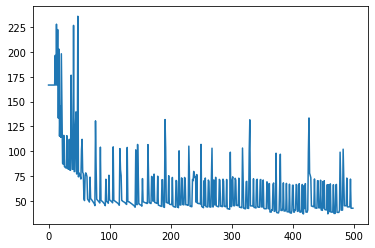

In [32]:
#@title Doing Weight Updates

dt = args['timestep_size']
weights = initialize_weights(nb_inputs, nb_outputs, args)
print(type(weights))
plot_weight_distribution(weights)
epochs = 500
v_ij = torch.zeros((nb_inputs, nb_outputs), device=device, dtype=dtype)
r_0 = 5e-3 # basal learning rate
loss_rec = []
iteration = 0

for i in tqdm(range(epochs)):
  iteration += 1
  print("\n Iteration no:", iteration)
  mem_rec, spk_rec, error_rec, eligibility_rec, pre_trace_rec = run_single_neuron(input_trains, weights, target, args)

  loss = new_van_rossum_loss(spk_rec, target, args)
  print("\n Loss =", loss)
  loss_rec.append(loss.to(cpu))

 
  # Weight update
  weight_updates = torch.sum(error_rec * eligibility_rec, dim=2)
  #print(weight_updates.shape)
#  print("Weight Updates:", weight_updates.T)

  # per-parameter learning rate
  gamma = float(np.exp(-dt/args['tau_rms']))
 # print("Gamma =", gamma)
 # g_ij2 = (error_rec * eligibility_rec)[:, :, -1]**2

  g_ij2 = torch.sum((error_rec * eligibility_rec)**2, dim=2)
  
#  print("g_ij2 =", g_ij2)
  v_ij = torch.max(gamma*v_ij, g_ij2)

  r_ij = r_0 / torch.sqrt(v_ij)
  rate_med = torch.median(r_ij)
  print("Median Learning Rate:", rate_med)
  rate_mean = torch.mean(r_ij)
  print("Avg. Learning Rate:", rate_mean)
#  print("Per-parameter learning rates:", r_ij.T)
#  print("change in weights =", (r_ij*weight_updates).T)
  weights += r_ij * weight_updates
#  plot_neuron_dynamics(mem_rec, spk_rec, error_rec, target)

#plt.savefig(f"{images_dir}/10 epoch evolution.png")
plt.plot(loss_rec)

Weight initialization done
<class 'torch.Tensor'>


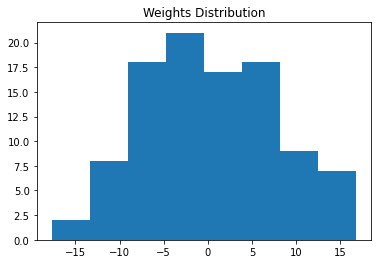

  0%|          | 0/500 [00:00<?, ?it/s]


 Iteration no: 1


  0%|          | 1/500 [00:04<38:55,  4.68s/it]


 Loss = tensor(312.1713)
Median Learning Rate: tensor(0.0008)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 2


  0%|          | 2/500 [00:08<35:06,  4.23s/it]


 Loss = tensor(302.2208)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 3


  1%|          | 3/500 [00:12<33:31,  4.05s/it]


 Loss = tensor(287.6447)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 4


  1%|          | 4/500 [00:16<32:16,  3.90s/it]


 Loss = tensor(287.7021)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 5


  1%|          | 5/500 [00:19<32:00,  3.88s/it]


 Loss = tensor(302.1001)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 6


  1%|          | 6/500 [00:23<31:44,  3.85s/it]


 Loss = tensor(194.8897)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 7


  1%|▏         | 7/500 [00:27<31:50,  3.88s/it]


 Loss = tensor(257.9959)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 8


  2%|▏         | 8/500 [00:31<31:32,  3.85s/it]


 Loss = tensor(195.1768)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 9


  2%|▏         | 9/500 [00:35<31:54,  3.90s/it]


 Loss = tensor(226.8075)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 10


  2%|▏         | 10/500 [00:39<31:42,  3.88s/it]


 Loss = tensor(210.1239)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 11


  2%|▏         | 11/500 [00:43<31:35,  3.88s/it]


 Loss = tensor(195.6605)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 12


  2%|▏         | 12/500 [00:46<31:12,  3.84s/it]


 Loss = tensor(241.3469)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 13


  3%|▎         | 13/500 [00:51<31:57,  3.94s/it]


 Loss = tensor(195.2609)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 14


  3%|▎         | 14/500 [00:54<31:17,  3.86s/it]


 Loss = tensor(227.1047)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 15


  3%|▎         | 15/500 [00:58<30:34,  3.78s/it]


 Loss = tensor(165.2343)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 16


  3%|▎         | 16/500 [01:02<30:17,  3.76s/it]


 Loss = tensor(191.6834)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 17


  3%|▎         | 17/500 [01:06<30:39,  3.81s/it]


 Loss = tensor(210.9453)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 18


  4%|▎         | 18/500 [01:09<30:43,  3.83s/it]


 Loss = tensor(159.6162)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 19


  4%|▍         | 19/500 [01:13<30:20,  3.78s/it]


 Loss = tensor(163.3740)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 20


  4%|▍         | 20/500 [01:17<30:42,  3.84s/it]


 Loss = tensor(205.9022)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 21


  4%|▍         | 21/500 [01:21<30:10,  3.78s/it]


 Loss = tensor(155.3935)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 22


  4%|▍         | 22/500 [01:24<30:11,  3.79s/it]


 Loss = tensor(159.7960)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 23


  5%|▍         | 23/500 [01:28<30:25,  3.83s/it]


 Loss = tensor(153.5942)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 24


  5%|▍         | 24/500 [01:32<30:12,  3.81s/it]


 Loss = tensor(164.2907)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 25


  5%|▌         | 25/500 [01:36<30:49,  3.89s/it]


 Loss = tensor(153.8225)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 26


  5%|▌         | 26/500 [01:40<30:41,  3.89s/it]


 Loss = tensor(178.4414)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0007)

 Iteration no: 27


  5%|▌         | 27/500 [01:44<30:38,  3.89s/it]


 Loss = tensor(153.8866)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 28


  6%|▌         | 28/500 [01:48<31:14,  3.97s/it]


 Loss = tensor(161.3063)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 29


  6%|▌         | 29/500 [01:52<31:17,  3.99s/it]


 Loss = tensor(173.6414)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 30


  6%|▌         | 30/500 [01:56<31:11,  3.98s/it]


 Loss = tensor(161.1977)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 31


  6%|▌         | 31/500 [02:00<31:15,  4.00s/it]


 Loss = tensor(160.0858)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 32


  6%|▋         | 32/500 [02:04<31:07,  3.99s/it]


 Loss = tensor(161.3775)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 33


  7%|▋         | 33/500 [02:08<30:34,  3.93s/it]


 Loss = tensor(162.5513)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 34


  7%|▋         | 34/500 [02:12<29:37,  3.81s/it]


 Loss = tensor(154.6474)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 35


  7%|▋         | 35/500 [02:15<29:23,  3.79s/it]


 Loss = tensor(161.8136)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 36


  7%|▋         | 36/500 [02:19<30:17,  3.92s/it]


 Loss = tensor(176.0885)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 37


  7%|▋         | 37/500 [02:23<29:55,  3.88s/it]


 Loss = tensor(160.6715)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 38


  8%|▊         | 38/500 [02:27<29:23,  3.82s/it]


 Loss = tensor(175.1104)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 39


  8%|▊         | 39/500 [02:31<29:12,  3.80s/it]


 Loss = tensor(160.2699)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 40


  8%|▊         | 40/500 [02:34<28:53,  3.77s/it]


 Loss = tensor(158.4670)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 41


  8%|▊         | 41/500 [02:38<28:47,  3.76s/it]


 Loss = tensor(161.0496)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 42


  8%|▊         | 42/500 [02:42<28:31,  3.74s/it]


 Loss = tensor(158.5054)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 43


  9%|▊         | 43/500 [02:46<28:43,  3.77s/it]


 Loss = tensor(161.8214)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 44


  9%|▉         | 44/500 [02:50<29:15,  3.85s/it]


 Loss = tensor(173.9852)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 45


  9%|▉         | 45/500 [02:53<28:47,  3.80s/it]


 Loss = tensor(161.6270)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 46


  9%|▉         | 46/500 [02:57<28:26,  3.76s/it]


 Loss = tensor(155.2059)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 47


  9%|▉         | 47/500 [03:01<29:29,  3.91s/it]


 Loss = tensor(166.6394)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 48


 10%|▉         | 48/500 [03:05<29:41,  3.94s/it]


 Loss = tensor(158.4154)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 49


 10%|▉         | 49/500 [03:09<30:01,  3.99s/it]


 Loss = tensor(169.5088)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 50


 10%|█         | 50/500 [03:13<29:46,  3.97s/it]


 Loss = tensor(178.2917)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 51


 10%|█         | 51/500 [03:17<29:08,  3.89s/it]


 Loss = tensor(154.1346)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 52


 10%|█         | 52/500 [03:21<29:18,  3.93s/it]


 Loss = tensor(168.3969)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 53


 11%|█         | 53/500 [03:25<29:12,  3.92s/it]


 Loss = tensor(177.9872)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 54


 11%|█         | 54/500 [03:29<29:25,  3.96s/it]


 Loss = tensor(168.4056)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 55


 11%|█         | 55/500 [03:33<28:38,  3.86s/it]


 Loss = tensor(163.2516)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 56


 11%|█         | 56/500 [03:37<29:20,  3.97s/it]


 Loss = tensor(154.4734)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0008)

 Iteration no: 57


 11%|█▏        | 57/500 [03:41<29:54,  4.05s/it]


 Loss = tensor(172.6256)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 58


 12%|█▏        | 58/500 [03:45<30:16,  4.11s/it]


 Loss = tensor(170.4471)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 59


 12%|█▏        | 59/500 [03:49<29:57,  4.08s/it]


 Loss = tensor(172.6236)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 60


 12%|█▏        | 60/500 [03:54<30:13,  4.12s/it]


 Loss = tensor(159.5302)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 61


 12%|█▏        | 61/500 [03:57<28:54,  3.95s/it]


 Loss = tensor(158.2675)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 62


 12%|█▏        | 62/500 [04:01<28:51,  3.95s/it]


 Loss = tensor(170.5497)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 63


 13%|█▎        | 63/500 [04:05<29:11,  4.01s/it]


 Loss = tensor(180.1718)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 64


 13%|█▎        | 64/500 [04:09<28:35,  3.94s/it]


 Loss = tensor(154.5685)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 65


 13%|█▎        | 65/500 [04:13<28:12,  3.89s/it]


 Loss = tensor(188.4723)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 66


 13%|█▎        | 66/500 [04:17<28:04,  3.88s/it]


 Loss = tensor(158.1671)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 67


 13%|█▎        | 67/500 [04:20<27:34,  3.82s/it]


 Loss = tensor(157.6517)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 68


 14%|█▎        | 68/500 [04:24<27:15,  3.79s/it]


 Loss = tensor(169.9783)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 69


 14%|█▍        | 69/500 [04:28<27:18,  3.80s/it]


 Loss = tensor(162.0435)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 70


 14%|█▍        | 70/500 [04:32<28:26,  3.97s/it]


 Loss = tensor(171.0353)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 71


 14%|█▍        | 71/500 [04:36<28:32,  3.99s/it]


 Loss = tensor(180.0883)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 72


 14%|█▍        | 72/500 [04:40<28:11,  3.95s/it]


 Loss = tensor(154.7511)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 73


 15%|█▍        | 73/500 [04:44<28:05,  3.95s/it]


 Loss = tensor(174.8384)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 74


 15%|█▍        | 74/500 [04:48<27:28,  3.87s/it]


 Loss = tensor(159.4807)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 75


 15%|█▌        | 75/500 [04:51<26:58,  3.81s/it]


 Loss = tensor(177.8264)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 76


 15%|█▌        | 76/500 [04:55<26:28,  3.75s/it]


 Loss = tensor(171.4426)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 77


 15%|█▌        | 77/500 [04:59<26:38,  3.78s/it]


 Loss = tensor(164.3274)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 78


 16%|█▌        | 78/500 [05:03<27:36,  3.93s/it]


 Loss = tensor(160.7359)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 79


 16%|█▌        | 79/500 [05:07<26:56,  3.84s/it]


 Loss = tensor(172.4534)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 80


 16%|█▌        | 80/500 [05:11<27:18,  3.90s/it]


 Loss = tensor(178.8478)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 81


 16%|█▌        | 81/500 [05:15<27:03,  3.88s/it]


 Loss = tensor(158.0588)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 82


 16%|█▋        | 82/500 [05:19<27:32,  3.95s/it]


 Loss = tensor(157.5676)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 83


 17%|█▋        | 83/500 [05:23<27:26,  3.95s/it]


 Loss = tensor(173.0171)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 84


 17%|█▋        | 84/500 [05:27<27:47,  4.01s/it]


 Loss = tensor(179.1208)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 85


 17%|█▋        | 85/500 [05:31<27:00,  3.90s/it]


 Loss = tensor(154.2247)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 86


 17%|█▋        | 86/500 [05:34<26:34,  3.85s/it]


 Loss = tensor(175.2154)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 87


 17%|█▋        | 87/500 [05:38<25:57,  3.77s/it]


 Loss = tensor(183.5592)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 88


 18%|█▊        | 88/500 [05:42<26:10,  3.81s/it]


 Loss = tensor(172.2049)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 89


 18%|█▊        | 89/500 [05:46<26:36,  3.88s/it]


 Loss = tensor(160.5515)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0009)

 Iteration no: 90


 18%|█▊        | 90/500 [05:50<26:39,  3.90s/it]


 Loss = tensor(163.9964)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 91


 18%|█▊        | 91/500 [05:54<26:49,  3.94s/it]


 Loss = tensor(159.0419)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 92


 18%|█▊        | 92/500 [05:57<26:19,  3.87s/it]


 Loss = tensor(173.5101)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 93


 19%|█▊        | 93/500 [06:02<26:55,  3.97s/it]


 Loss = tensor(151.0492)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 94


 19%|█▉        | 94/500 [06:05<26:29,  3.91s/it]


 Loss = tensor(129.8525)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 95


 19%|█▉        | 95/500 [06:09<26:32,  3.93s/it]


 Loss = tensor(156.1279)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 96


 19%|█▉        | 96/500 [06:13<26:10,  3.89s/it]


 Loss = tensor(128.2415)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 97


 19%|█▉        | 97/500 [06:17<25:46,  3.84s/it]


 Loss = tensor(173.2718)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 98


 20%|█▉        | 98/500 [06:21<25:49,  3.85s/it]


 Loss = tensor(135.1026)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 99


 20%|█▉        | 99/500 [06:25<26:10,  3.92s/it]


 Loss = tensor(132.5265)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 100


 20%|██        | 100/500 [06:29<25:47,  3.87s/it]


 Loss = tensor(127.2346)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 101


 20%|██        | 101/500 [06:32<25:25,  3.82s/it]


 Loss = tensor(148.1469)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 102


 20%|██        | 102/500 [06:37<26:05,  3.93s/it]


 Loss = tensor(125.5893)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 103


 21%|██        | 103/500 [06:40<25:31,  3.86s/it]


 Loss = tensor(145.0177)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 104


 21%|██        | 104/500 [06:44<25:51,  3.92s/it]


 Loss = tensor(126.0983)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 105


 21%|██        | 105/500 [06:48<25:33,  3.88s/it]


 Loss = tensor(171.9159)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 106


 21%|██        | 106/500 [06:52<25:05,  3.82s/it]


 Loss = tensor(133.4725)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 107


 21%|██▏       | 107/500 [06:56<25:19,  3.87s/it]


 Loss = tensor(131.0619)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 108


 22%|██▏       | 108/500 [06:59<25:02,  3.83s/it]


 Loss = tensor(126.3104)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 109


 22%|██▏       | 109/500 [07:04<25:20,  3.89s/it]


 Loss = tensor(187.5472)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 110


 22%|██▏       | 110/500 [07:07<24:48,  3.82s/it]


 Loss = tensor(133.1557)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 111


 22%|██▏       | 111/500 [07:11<25:09,  3.88s/it]


 Loss = tensor(129.0951)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 112


 22%|██▏       | 112/500 [07:15<25:24,  3.93s/it]


 Loss = tensor(148.9807)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 113


 23%|██▎       | 113/500 [07:19<24:48,  3.85s/it]


 Loss = tensor(128.0000)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 114


 23%|██▎       | 114/500 [07:23<24:34,  3.82s/it]


 Loss = tensor(124.5806)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0010)

 Iteration no: 115


 23%|██▎       | 115/500 [07:26<24:14,  3.78s/it]


 Loss = tensor(143.7369)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 116


 23%|██▎       | 116/500 [07:30<24:01,  3.75s/it]


 Loss = tensor(174.0605)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 117


 23%|██▎       | 117/500 [07:34<24:01,  3.76s/it]


 Loss = tensor(129.3372)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 118


 24%|██▎       | 118/500 [07:38<23:56,  3.76s/it]


 Loss = tensor(124.5224)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 119


 24%|██▍       | 119/500 [07:42<24:27,  3.85s/it]


 Loss = tensor(142.2143)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 120


 24%|██▍       | 120/500 [07:46<24:27,  3.86s/it]


 Loss = tensor(121.9915)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 121


 24%|██▍       | 121/500 [07:50<24:58,  3.95s/it]


 Loss = tensor(125.4991)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 122


 24%|██▍       | 122/500 [07:53<24:30,  3.89s/it]


 Loss = tensor(172.1358)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 123


 25%|██▍       | 123/500 [07:58<25:30,  4.06s/it]


 Loss = tensor(140.3382)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 124


 25%|██▍       | 124/500 [08:01<24:34,  3.92s/it]


 Loss = tensor(128.0325)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 125


 25%|██▌       | 125/500 [08:05<23:53,  3.82s/it]


 Loss = tensor(124.6154)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 126


 25%|██▌       | 126/500 [08:09<24:11,  3.88s/it]


 Loss = tensor(121.7598)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 127


 25%|██▌       | 127/500 [08:13<23:53,  3.84s/it]


 Loss = tensor(146.2942)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 128


 26%|██▌       | 128/500 [08:17<24:11,  3.90s/it]


 Loss = tensor(145.6429)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 129


 26%|██▌       | 129/500 [08:21<25:16,  4.09s/it]


 Loss = tensor(127.1055)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 130


 26%|██▌       | 130/500 [08:25<24:25,  3.96s/it]


 Loss = tensor(138.3757)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 131


 26%|██▌       | 131/500 [08:29<23:52,  3.88s/it]


 Loss = tensor(125.1982)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 132


 26%|██▋       | 132/500 [08:33<23:57,  3.91s/it]


 Loss = tensor(122.8604)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 133


 27%|██▋       | 133/500 [08:36<23:36,  3.86s/it]


 Loss = tensor(119.8940)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 134


 27%|██▋       | 134/500 [08:40<23:19,  3.82s/it]


 Loss = tensor(137.5557)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 135


 27%|██▋       | 135/500 [08:44<23:06,  3.80s/it]


 Loss = tensor(169.9204)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 136


 27%|██▋       | 136/500 [08:48<24:00,  3.96s/it]


 Loss = tensor(121.4542)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 137


 27%|██▋       | 137/500 [08:52<23:38,  3.91s/it]


 Loss = tensor(139.9565)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 138


 28%|██▊       | 138/500 [08:56<23:36,  3.91s/it]


 Loss = tensor(122.3608)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 139


 28%|██▊       | 139/500 [09:00<22:57,  3.81s/it]


 Loss = tensor(120.0166)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 140


 28%|██▊       | 140/500 [09:03<22:28,  3.75s/it]


 Loss = tensor(143.9857)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 141


 28%|██▊       | 141/500 [09:07<22:25,  3.75s/it]


 Loss = tensor(145.7625)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 142


 28%|██▊       | 142/500 [09:11<22:41,  3.80s/it]


 Loss = tensor(149.3351)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 143


 29%|██▊       | 143/500 [09:14<22:16,  3.74s/it]


 Loss = tensor(122.6391)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 144


 29%|██▉       | 144/500 [09:18<22:24,  3.78s/it]


 Loss = tensor(119.2860)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 145


 29%|██▉       | 145/500 [09:22<22:38,  3.83s/it]


 Loss = tensor(137.9765)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 146


 29%|██▉       | 146/500 [09:26<22:48,  3.87s/it]


 Loss = tensor(119.9398)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 147


 29%|██▉       | 147/500 [09:31<23:32,  4.00s/it]


 Loss = tensor(117.0443)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 148


 30%|██▉       | 148/500 [09:34<23:12,  3.96s/it]


 Loss = tensor(165.2218)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 149


 30%|██▉       | 149/500 [09:38<22:31,  3.85s/it]


 Loss = tensor(137.8866)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 150


 30%|███       | 150/500 [09:42<22:42,  3.89s/it]


 Loss = tensor(119.6652)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 151


 30%|███       | 151/500 [09:46<22:12,  3.82s/it]


 Loss = tensor(116.1387)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 152


 30%|███       | 152/500 [09:49<21:51,  3.77s/it]


 Loss = tensor(140.4037)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 153


 31%|███       | 153/500 [09:53<22:31,  3.90s/it]


 Loss = tensor(137.1175)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 154


 31%|███       | 154/500 [09:58<22:44,  3.94s/it]


 Loss = tensor(134.8790)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 155


 31%|███       | 155/500 [10:01<22:07,  3.85s/it]


 Loss = tensor(117.0912)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 156


 31%|███       | 156/500 [10:05<22:01,  3.84s/it]


 Loss = tensor(141.6725)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 157


 31%|███▏      | 157/500 [10:09<22:14,  3.89s/it]


 Loss = tensor(147.2603)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 158


 32%|███▏      | 158/500 [10:13<22:53,  4.02s/it]


 Loss = tensor(120.9271)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 159


 32%|███▏      | 159/500 [10:17<22:07,  3.89s/it]


 Loss = tensor(119.1483)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 160


 32%|███▏      | 160/500 [10:21<22:18,  3.94s/it]


 Loss = tensor(117.3404)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 161


 32%|███▏      | 161/500 [10:25<22:06,  3.91s/it]


 Loss = tensor(135.5128)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 162


 32%|███▏      | 162/500 [10:28<21:41,  3.85s/it]


 Loss = tensor(118.6650)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 163


 33%|███▎      | 163/500 [10:32<21:46,  3.88s/it]


 Loss = tensor(165.6256)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 164


 33%|███▎      | 164/500 [10:36<21:18,  3.80s/it]


 Loss = tensor(133.7935)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 165


 33%|███▎      | 165/500 [10:40<20:59,  3.76s/it]


 Loss = tensor(94.1283)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 166


 33%|███▎      | 166/500 [10:44<21:44,  3.91s/it]


 Loss = tensor(141.0296)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 167


 33%|███▎      | 167/500 [10:48<22:04,  3.98s/it]


 Loss = tensor(136.2995)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 168


 34%|███▎      | 168/500 [10:52<21:29,  3.88s/it]


 Loss = tensor(118.9015)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 169


 34%|███▍      | 169/500 [10:56<21:14,  3.85s/it]


 Loss = tensor(97.6386)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0011)

 Iteration no: 170


 34%|███▍      | 170/500 [10:59<20:53,  3.80s/it]


 Loss = tensor(94.4383)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 171


 34%|███▍      | 171/500 [11:03<20:42,  3.78s/it]


 Loss = tensor(142.4808)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 172


 34%|███▍      | 172/500 [11:07<21:13,  3.88s/it]


 Loss = tensor(138.3437)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 173


 35%|███▍      | 173/500 [11:11<20:49,  3.82s/it]


 Loss = tensor(115.5743)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 174


 35%|███▍      | 174/500 [11:15<21:28,  3.95s/it]


 Loss = tensor(96.7245)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 175


 35%|███▌      | 175/500 [11:19<21:18,  3.93s/it]


 Loss = tensor(94.4130)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 176


 35%|███▌      | 176/500 [11:23<20:49,  3.86s/it]


 Loss = tensor(115.8537)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 177


 35%|███▌      | 177/500 [11:26<20:39,  3.84s/it]


 Loss = tensor(112.2989)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 178


 36%|███▌      | 178/500 [11:30<20:33,  3.83s/it]


 Loss = tensor(93.6218)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 179


 36%|███▌      | 179/500 [11:34<20:38,  3.86s/it]


 Loss = tensor(165.8570)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 180


 36%|███▌      | 180/500 [11:38<20:31,  3.85s/it]


 Loss = tensor(111.0348)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 181


 36%|███▌      | 181/500 [11:42<20:41,  3.89s/it]


 Loss = tensor(117.7991)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 182


 36%|███▋      | 182/500 [11:46<20:20,  3.84s/it]


 Loss = tensor(114.7758)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 183


 37%|███▋      | 183/500 [11:49<20:05,  3.80s/it]


 Loss = tensor(96.1546)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 184


 37%|███▋      | 184/500 [11:53<20:21,  3.87s/it]


 Loss = tensor(93.8737)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 185


 37%|███▋      | 185/500 [11:57<20:22,  3.88s/it]


 Loss = tensor(132.0149)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 186


 37%|███▋      | 186/500 [12:01<20:02,  3.83s/it]


 Loss = tensor(118.8513)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 187


 37%|███▋      | 187/500 [12:05<19:41,  3.77s/it]


 Loss = tensor(92.7327)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 188


 38%|███▊      | 188/500 [12:09<19:51,  3.82s/it]


 Loss = tensor(163.8077)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 189


 38%|███▊      | 189/500 [12:12<19:30,  3.76s/it]


 Loss = tensor(98.4177)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0012)

 Iteration no: 190


 38%|███▊      | 190/500 [12:16<19:39,  3.81s/it]


 Loss = tensor(112.5436)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 191


 38%|███▊      | 191/500 [12:20<19:20,  3.76s/it]


 Loss = tensor(93.9534)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 192


 38%|███▊      | 192/500 [12:23<19:06,  3.72s/it]


 Loss = tensor(91.7316)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 193


 39%|███▊      | 193/500 [12:27<19:21,  3.78s/it]


 Loss = tensor(139.2552)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 194


 39%|███▉      | 194/500 [12:31<19:44,  3.87s/it]


 Loss = tensor(121.8518)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 195


 39%|███▉      | 195/500 [12:35<19:39,  3.87s/it]


 Loss = tensor(95.4765)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 196


 39%|███▉      | 196/500 [12:39<19:15,  3.80s/it]


 Loss = tensor(93.8236)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 197


 39%|███▉      | 197/500 [12:43<19:12,  3.80s/it]


 Loss = tensor(129.5863)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 198


 40%|███▉      | 198/500 [12:46<18:58,  3.77s/it]


 Loss = tensor(111.6429)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 199


 40%|███▉      | 199/500 [12:51<19:33,  3.90s/it]


 Loss = tensor(92.7908)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 200


 40%|████      | 200/500 [12:55<19:43,  3.94s/it]


 Loss = tensor(117.5852)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 201


 40%|████      | 201/500 [12:58<19:12,  3.85s/it]


 Loss = tensor(94.5326)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 202


 40%|████      | 202/500 [13:02<18:59,  3.82s/it]


 Loss = tensor(108.3777)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 203


 41%|████      | 203/500 [13:06<18:58,  3.83s/it]


 Loss = tensor(114.4417)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 204


 41%|████      | 204/500 [13:10<19:08,  3.88s/it]


 Loss = tensor(117.2094)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 205


 41%|████      | 205/500 [13:14<19:23,  3.94s/it]


 Loss = tensor(141.6686)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 206


 41%|████      | 206/500 [13:18<18:56,  3.87s/it]


 Loss = tensor(93.2211)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 207


 41%|████▏     | 207/500 [13:21<18:45,  3.84s/it]


 Loss = tensor(115.2859)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 208


 42%|████▏     | 208/500 [13:25<18:28,  3.80s/it]


 Loss = tensor(111.9685)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 209


 42%|████▏     | 209/500 [13:29<18:16,  3.77s/it]


 Loss = tensor(116.0208)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 210


 42%|████▏     | 210/500 [13:33<18:23,  3.81s/it]


 Loss = tensor(115.9274)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 211


 42%|████▏     | 211/500 [13:36<18:00,  3.74s/it]


 Loss = tensor(92.9037)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 212


 42%|████▏     | 212/500 [13:40<17:45,  3.70s/it]


 Loss = tensor(115.2941)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 213


 43%|████▎     | 213/500 [13:44<17:37,  3.69s/it]


 Loss = tensor(112.0820)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 214


 43%|████▎     | 214/500 [13:47<17:33,  3.68s/it]


 Loss = tensor(93.9388)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 215


 43%|████▎     | 215/500 [13:51<17:29,  3.68s/it]


 Loss = tensor(107.8220)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 216


 43%|████▎     | 216/500 [13:55<18:33,  3.92s/it]


 Loss = tensor(89.3000)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 217


 43%|████▎     | 217/500 [13:59<18:11,  3.86s/it]


 Loss = tensor(138.9995)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 218


 44%|████▎     | 218/500 [14:03<18:06,  3.85s/it]


 Loss = tensor(119.1828)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 219


 44%|████▍     | 219/500 [14:07<17:51,  3.81s/it]


 Loss = tensor(93.9095)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 220


 44%|████▍     | 220/500 [14:10<17:35,  3.77s/it]


 Loss = tensor(92.6149)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 221


 44%|████▍     | 221/500 [14:14<17:25,  3.75s/it]


 Loss = tensor(130.0662)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 222


 44%|████▍     | 222/500 [14:18<17:08,  3.70s/it]


 Loss = tensor(117.4881)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 223


 45%|████▍     | 223/500 [14:21<17:08,  3.71s/it]


 Loss = tensor(142.1810)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 224


 45%|████▍     | 224/500 [14:25<17:03,  3.71s/it]


 Loss = tensor(93.5302)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 225


 45%|████▌     | 225/500 [14:29<16:59,  3.71s/it]


 Loss = tensor(91.9220)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 226


 45%|████▌     | 226/500 [14:33<17:15,  3.78s/it]


 Loss = tensor(129.2726)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 227


 45%|████▌     | 227/500 [14:37<17:13,  3.79s/it]


 Loss = tensor(109.7710)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 228


 46%|████▌     | 228/500 [14:40<17:08,  3.78s/it]


 Loss = tensor(91.8558)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 229


 46%|████▌     | 229/500 [14:44<16:47,  3.72s/it]


 Loss = tensor(140.3963)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 230


 46%|████▌     | 230/500 [14:48<16:37,  3.69s/it]


 Loss = tensor(108.7235)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 231


 46%|████▌     | 231/500 [14:51<16:32,  3.69s/it]


 Loss = tensor(90.5126)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 232


 46%|████▋     | 232/500 [14:55<16:26,  3.68s/it]


 Loss = tensor(135.8767)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 233


 47%|████▋     | 233/500 [14:59<16:21,  3.68s/it]


 Loss = tensor(92.1545)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 234


 47%|████▋     | 234/500 [15:02<16:20,  3.69s/it]


 Loss = tensor(90.0408)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 235


 47%|████▋     | 235/500 [15:06<16:22,  3.71s/it]


 Loss = tensor(132.3663)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 236


 47%|████▋     | 236/500 [15:10<16:24,  3.73s/it]


 Loss = tensor(92.3732)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 237


 47%|████▋     | 237/500 [15:13<16:17,  3.72s/it]


 Loss = tensor(113.7500)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 238


 48%|████▊     | 238/500 [15:17<16:02,  3.67s/it]


 Loss = tensor(162.7909)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 239


 48%|████▊     | 239/500 [15:21<15:45,  3.62s/it]


 Loss = tensor(111.5393)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 240


 48%|████▊     | 240/500 [15:24<15:52,  3.66s/it]


 Loss = tensor(93.6284)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 241


 48%|████▊     | 241/500 [15:28<15:45,  3.65s/it]


 Loss = tensor(115.0931)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 242


 48%|████▊     | 242/500 [15:32<15:59,  3.72s/it]


 Loss = tensor(113.7986)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 243


 49%|████▊     | 243/500 [15:36<16:35,  3.87s/it]


 Loss = tensor(93.6490)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 244


 49%|████▉     | 244/500 [15:40<16:18,  3.82s/it]


 Loss = tensor(109.2606)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 245


 49%|████▉     | 245/500 [15:44<16:23,  3.86s/it]


 Loss = tensor(91.1855)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 246


 49%|████▉     | 246/500 [15:47<16:07,  3.81s/it]


 Loss = tensor(112.7866)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 247


 49%|████▉     | 247/500 [15:51<16:08,  3.83s/it]


 Loss = tensor(138.0772)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 248


 50%|████▉     | 248/500 [15:55<16:13,  3.86s/it]


 Loss = tensor(118.3448)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 249


 50%|████▉     | 249/500 [15:59<15:51,  3.79s/it]


 Loss = tensor(92.9520)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 250


 50%|█████     | 250/500 [16:03<15:56,  3.83s/it]


 Loss = tensor(91.7033)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 251


 50%|█████     | 251/500 [16:06<15:41,  3.78s/it]


 Loss = tensor(105.9460)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 252


 50%|█████     | 252/500 [16:11<16:08,  3.91s/it]


 Loss = tensor(112.9087)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 253


 51%|█████     | 253/500 [16:15<16:07,  3.92s/it]


 Loss = tensor(109.6169)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 254


 51%|█████     | 254/500 [16:18<15:49,  3.86s/it]


 Loss = tensor(114.8158)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 255


 51%|█████     | 255/500 [16:22<15:29,  3.79s/it]


 Loss = tensor(89.0620)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 256


 51%|█████     | 256/500 [16:26<15:30,  3.82s/it]


 Loss = tensor(87.5743)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 257


 51%|█████▏    | 257/500 [16:29<15:14,  3.76s/it]


 Loss = tensor(179.6980)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 258


 52%|█████▏    | 258/500 [16:33<15:03,  3.73s/it]


 Loss = tensor(91.7170)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 259


 52%|█████▏    | 259/500 [16:37<15:16,  3.80s/it]


 Loss = tensor(138.3349)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 260


 52%|█████▏    | 260/500 [16:41<15:05,  3.77s/it]


 Loss = tensor(110.6099)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 261


 52%|█████▏    | 261/500 [16:45<15:16,  3.84s/it]


 Loss = tensor(93.0420)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 262


 52%|█████▏    | 262/500 [16:49<15:19,  3.87s/it]


 Loss = tensor(115.1079)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 263


 53%|█████▎    | 263/500 [16:53<15:19,  3.88s/it]


 Loss = tensor(89.8583)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 264


 53%|█████▎    | 264/500 [16:56<15:00,  3.82s/it]


 Loss = tensor(113.4968)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 265


 53%|█████▎    | 265/500 [17:00<14:57,  3.82s/it]


 Loss = tensor(110.1935)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 266


 53%|█████▎    | 266/500 [17:04<15:12,  3.90s/it]


 Loss = tensor(115.2511)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 267


 53%|█████▎    | 267/500 [17:08<14:54,  3.84s/it]


 Loss = tensor(90.2300)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 268


 54%|█████▎    | 268/500 [17:12<14:39,  3.79s/it]


 Loss = tensor(89.2942)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 269


 54%|█████▍    | 269/500 [17:15<14:47,  3.84s/it]


 Loss = tensor(105.4970)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 270


 54%|█████▍    | 270/500 [17:19<14:48,  3.86s/it]


 Loss = tensor(134.7515)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 271


 54%|█████▍    | 271/500 [17:23<14:49,  3.89s/it]


 Loss = tensor(90.6455)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 272


 54%|█████▍    | 272/500 [17:27<14:53,  3.92s/it]


 Loss = tensor(113.4852)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 273


 55%|█████▍    | 273/500 [17:31<14:43,  3.89s/it]


 Loss = tensor(137.8093)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 274


 55%|█████▍    | 274/500 [17:35<14:25,  3.83s/it]


 Loss = tensor(106.2544)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 275


 55%|█████▌    | 275/500 [17:39<14:40,  3.92s/it]


 Loss = tensor(88.3777)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 276


 55%|█████▌    | 276/500 [17:43<14:13,  3.81s/it]


 Loss = tensor(135.2699)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 277


 55%|█████▌    | 277/500 [17:46<14:01,  3.77s/it]


 Loss = tensor(114.4043)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 278


 56%|█████▌    | 278/500 [17:50<14:18,  3.87s/it]


 Loss = tensor(88.7640)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 279


 56%|█████▌    | 279/500 [17:54<14:27,  3.93s/it]


 Loss = tensor(88.4434)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 280


 56%|█████▌    | 280/500 [17:58<14:14,  3.88s/it]


 Loss = tensor(104.6409)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 281


 56%|█████▌    | 281/500 [18:02<14:04,  3.86s/it]


 Loss = tensor(110.5809)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 282


 56%|█████▋    | 282/500 [18:06<14:00,  3.86s/it]


 Loss = tensor(160.0774)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 283


 57%|█████▋    | 283/500 [18:10<14:29,  4.01s/it]


 Loss = tensor(115.2352)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 284


 57%|█████▋    | 284/500 [18:14<14:33,  4.04s/it]


 Loss = tensor(89.3324)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 285


 57%|█████▋    | 285/500 [18:18<14:35,  4.07s/it]


 Loss = tensor(105.8462)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 286


 57%|█████▋    | 286/500 [18:22<14:10,  3.98s/it]


 Loss = tensor(111.7854)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 287


 57%|█████▋    | 287/500 [18:26<14:07,  3.98s/it]


 Loss = tensor(111.4500)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 288


 58%|█████▊    | 288/500 [18:30<13:55,  3.94s/it]


 Loss = tensor(107.4559)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 289


 58%|█████▊    | 289/500 [18:34<13:42,  3.90s/it]


 Loss = tensor(113.8701)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 290


 58%|█████▊    | 290/500 [18:38<13:40,  3.91s/it]


 Loss = tensor(88.4528)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 291


 58%|█████▊    | 291/500 [18:42<13:50,  3.97s/it]


 Loss = tensor(112.4215)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 292


 58%|█████▊    | 292/500 [18:46<13:28,  3.89s/it]


 Loss = tensor(111.1537)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 293


 59%|█████▊    | 293/500 [18:49<13:07,  3.80s/it]


 Loss = tensor(119.0636)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 294


 59%|█████▉    | 294/500 [18:53<12:55,  3.77s/it]


 Loss = tensor(105.7519)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 295


 59%|█████▉    | 295/500 [18:57<13:30,  3.95s/it]


 Loss = tensor(98.7413)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 296


 59%|█████▉    | 296/500 [19:01<13:24,  3.94s/it]


 Loss = tensor(87.2727)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 297


 59%|█████▉    | 297/500 [19:05<13:23,  3.96s/it]


 Loss = tensor(96.1169)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 298


 60%|█████▉    | 298/500 [19:09<13:07,  3.90s/it]


 Loss = tensor(98.3176)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 299


 60%|█████▉    | 299/500 [19:13<13:01,  3.89s/it]


 Loss = tensor(123.8701)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 300


 60%|██████    | 300/500 [19:17<13:27,  4.04s/it]


 Loss = tensor(89.7348)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 301


 60%|██████    | 301/500 [19:21<13:25,  4.05s/it]


 Loss = tensor(77.5086)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 302


 60%|██████    | 302/500 [19:25<12:59,  3.94s/it]


 Loss = tensor(101.7537)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 303


 61%|██████    | 303/500 [19:29<13:02,  3.97s/it]


 Loss = tensor(79.0014)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 304


 61%|██████    | 304/500 [19:33<12:49,  3.93s/it]


 Loss = tensor(76.2662)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0013)

 Iteration no: 305


 61%|██████    | 305/500 [19:37<12:41,  3.91s/it]


 Loss = tensor(97.8179)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 306


 61%|██████    | 306/500 [19:41<12:41,  3.93s/it]


 Loss = tensor(79.6832)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 307


 61%|██████▏   | 307/500 [19:45<12:42,  3.95s/it]


 Loss = tensor(77.0013)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 308


 62%|██████▏   | 308/500 [19:48<12:23,  3.87s/it]


 Loss = tensor(74.2199)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 309


 62%|██████▏   | 309/500 [19:52<12:15,  3.85s/it]


 Loss = tensor(76.0302)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 310


 62%|██████▏   | 310/500 [19:56<12:09,  3.84s/it]


 Loss = tensor(97.2518)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 311


 62%|██████▏   | 311/500 [20:00<12:06,  3.84s/it]


 Loss = tensor(76.6898)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 312


 62%|██████▏   | 312/500 [20:03<11:49,  3.77s/it]


 Loss = tensor(125.3725)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 313


 63%|██████▎   | 313/500 [20:07<11:59,  3.85s/it]


 Loss = tensor(76.7591)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 314


 63%|██████▎   | 314/500 [20:11<11:58,  3.86s/it]


 Loss = tensor(74.7902)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 315


 63%|██████▎   | 315/500 [20:15<12:00,  3.89s/it]


 Loss = tensor(102.1706)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 316


 63%|██████▎   | 316/500 [20:19<11:53,  3.88s/it]


 Loss = tensor(75.7777)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 317


 63%|██████▎   | 317/500 [20:23<11:39,  3.82s/it]


 Loss = tensor(98.6896)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 318


 64%|██████▎   | 318/500 [20:27<11:38,  3.84s/it]


 Loss = tensor(76.8595)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0014)

 Iteration no: 319


 64%|██████▍   | 319/500 [20:31<11:56,  3.96s/it]


 Loss = tensor(71.4843)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 320


 64%|██████▍   | 320/500 [20:35<11:39,  3.89s/it]


 Loss = tensor(75.7762)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 321


 64%|██████▍   | 321/500 [20:38<11:23,  3.82s/it]


 Loss = tensor(71.0483)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 322


 64%|██████▍   | 322/500 [20:42<11:25,  3.85s/it]


 Loss = tensor(122.6520)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 323


 65%|██████▍   | 323/500 [20:46<11:25,  3.87s/it]


 Loss = tensor(74.5243)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 324


 65%|██████▍   | 324/500 [20:50<11:11,  3.82s/it]


 Loss = tensor(81.2113)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 325


 65%|██████▌   | 325/500 [20:53<10:59,  3.77s/it]


 Loss = tensor(60.8447)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 326


 65%|██████▌   | 326/500 [20:57<11:00,  3.79s/it]


 Loss = tensor(57.3808)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 327


 65%|██████▌   | 327/500 [21:01<10:48,  3.75s/it]


 Loss = tensor(57.6333)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 328


 66%|██████▌   | 328/500 [21:05<10:41,  3.73s/it]


 Loss = tensor(55.2934)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 329


 66%|██████▌   | 329/500 [21:09<10:45,  3.77s/it]


 Loss = tensor(78.9825)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 330


 66%|██████▌   | 330/500 [21:12<10:50,  3.83s/it]


 Loss = tensor(58.1317)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 331


 66%|██████▌   | 331/500 [21:17<10:56,  3.88s/it]


 Loss = tensor(86.3425)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 332


 66%|██████▋   | 332/500 [21:20<10:39,  3.81s/it]


 Loss = tensor(59.9563)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 333


 67%|██████▋   | 333/500 [21:24<10:29,  3.77s/it]


 Loss = tensor(106.6261)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 334


 67%|██████▋   | 334/500 [21:29<11:16,  4.07s/it]


 Loss = tensor(75.6997)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 335


 67%|██████▋   | 335/500 [21:33<11:27,  4.17s/it]


 Loss = tensor(58.4072)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 336


 67%|██████▋   | 336/500 [21:37<11:10,  4.09s/it]


 Loss = tensor(80.0358)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 337


 67%|██████▋   | 337/500 [21:41<10:46,  3.97s/it]


 Loss = tensor(59.2294)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 338


 68%|██████▊   | 338/500 [21:44<10:32,  3.90s/it]


 Loss = tensor(59.1440)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 339


 68%|██████▊   | 339/500 [21:48<10:25,  3.88s/it]


 Loss = tensor(56.7641)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 340


 68%|██████▊   | 340/500 [21:52<10:27,  3.92s/it]


 Loss = tensor(56.1991)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 341


 68%|██████▊   | 341/500 [21:56<10:14,  3.87s/it]


 Loss = tensor(55.5536)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0017)

 Iteration no: 342


 68%|██████▊   | 342/500 [22:00<09:59,  3.79s/it]


 Loss = tensor(158.3356)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 343


 69%|██████▊   | 343/500 [22:03<09:43,  3.72s/it]


 Loss = tensor(79.3473)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0015)

 Iteration no: 344


 69%|██████▉   | 344/500 [22:07<09:40,  3.72s/it]


 Loss = tensor(59.7179)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 345


 69%|██████▉   | 345/500 [22:10<09:30,  3.68s/it]


 Loss = tensor(60.0167)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 346


 69%|██████▉   | 346/500 [22:14<09:37,  3.75s/it]


 Loss = tensor(59.5889)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 347


 69%|██████▉   | 347/500 [22:18<09:37,  3.77s/it]


 Loss = tensor(56.6569)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 348


 70%|██████▉   | 348/500 [22:22<09:49,  3.88s/it]


 Loss = tensor(80.9004)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 349


 70%|██████▉   | 349/500 [22:26<09:39,  3.84s/it]


 Loss = tensor(60.0277)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 350


 70%|███████   | 350/500 [22:30<09:30,  3.80s/it]


 Loss = tensor(57.6755)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0016)

 Iteration no: 351


 70%|███████   | 351/500 [22:34<09:32,  3.84s/it]


 Loss = tensor(57.9800)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0017)

 Iteration no: 352


 70%|███████   | 352/500 [22:37<09:25,  3.82s/it]


 Loss = tensor(106.4604)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0017)

 Iteration no: 353


 71%|███████   | 353/500 [22:41<09:12,  3.76s/it]


 Loss = tensor(58.3736)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0017)

 Iteration no: 354


 71%|███████   | 354/500 [22:45<09:32,  3.92s/it]


 Loss = tensor(79.4889)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0017)

 Iteration no: 355


 71%|███████   | 355/500 [22:50<09:46,  4.05s/it]


 Loss = tensor(59.2738)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0017)

 Iteration no: 356


 71%|███████   | 356/500 [22:53<09:31,  3.97s/it]


 Loss = tensor(58.8632)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0017)

 Iteration no: 357


 71%|███████▏  | 357/500 [22:57<09:16,  3.89s/it]


 Loss = tensor(84.5543)
Median Learning Rate: tensor(0.0004)
Avg. Learning Rate: tensor(0.0017)

 Iteration no: 358


 72%|███████▏  | 358/500 [23:01<09:15,  3.91s/it]


 Loss = tensor(59.1662)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0017)

 Iteration no: 359


 72%|███████▏  | 359/500 [23:05<08:58,  3.82s/it]


 Loss = tensor(58.4857)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0017)

 Iteration no: 360


 72%|███████▏  | 360/500 [23:08<08:50,  3.79s/it]


 Loss = tensor(58.0738)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0018)

 Iteration no: 361


 72%|███████▏  | 361/500 [23:12<08:46,  3.79s/it]


 Loss = tensor(79.7258)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0018)

 Iteration no: 362


 72%|███████▏  | 362/500 [23:16<08:56,  3.88s/it]


 Loss = tensor(58.9159)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0018)

 Iteration no: 363


 73%|███████▎  | 363/500 [23:20<08:43,  3.82s/it]


 Loss = tensor(58.8316)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0018)

 Iteration no: 364


 73%|███████▎  | 364/500 [23:24<08:32,  3.77s/it]


 Loss = tensor(106.1562)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0018)

 Iteration no: 365


 73%|███████▎  | 365/500 [23:27<08:24,  3.74s/it]


 Loss = tensor(57.6666)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0018)

 Iteration no: 366


 73%|███████▎  | 366/500 [23:31<08:20,  3.74s/it]


 Loss = tensor(56.9969)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0019)

 Iteration no: 367


 73%|███████▎  | 367/500 [23:35<08:37,  3.89s/it]


 Loss = tensor(81.4151)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0019)

 Iteration no: 368


 74%|███████▎  | 368/500 [23:39<08:23,  3.81s/it]


 Loss = tensor(58.0262)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0019)

 Iteration no: 369


 74%|███████▍  | 369/500 [23:43<08:23,  3.84s/it]


 Loss = tensor(57.7542)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0019)

 Iteration no: 370


 74%|███████▍  | 370/500 [23:47<08:25,  3.89s/it]


 Loss = tensor(57.0880)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0019)

 Iteration no: 371


 74%|███████▍  | 371/500 [23:51<08:15,  3.84s/it]


 Loss = tensor(133.2369)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0018)

 Iteration no: 372


 74%|███████▍  | 372/500 [23:54<08:10,  3.83s/it]


 Loss = tensor(58.8751)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0018)

 Iteration no: 373


 75%|███████▍  | 373/500 [23:58<08:12,  3.87s/it]


 Loss = tensor(58.1798)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0018)

 Iteration no: 374


 75%|███████▍  | 374/500 [24:02<08:07,  3.87s/it]


 Loss = tensor(81.7538)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0018)

 Iteration no: 375


 75%|███████▌  | 375/500 [24:06<08:00,  3.84s/it]


 Loss = tensor(60.9015)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0018)

 Iteration no: 376


 75%|███████▌  | 376/500 [24:10<07:49,  3.79s/it]


 Loss = tensor(58.2346)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0019)

 Iteration no: 377


 75%|███████▌  | 377/500 [24:13<07:41,  3.75s/it]


 Loss = tensor(58.2354)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0019)

 Iteration no: 378


 76%|███████▌  | 378/500 [24:17<07:43,  3.80s/it]


 Loss = tensor(57.8338)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0019)

 Iteration no: 379


 76%|███████▌  | 379/500 [24:21<07:39,  3.80s/it]


 Loss = tensor(55.2209)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0019)

 Iteration no: 380


 76%|███████▌  | 380/500 [24:25<07:29,  3.75s/it]


 Loss = tensor(79.7496)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0019)

 Iteration no: 381


 76%|███████▌  | 381/500 [24:29<07:29,  3.78s/it]


 Loss = tensor(58.6005)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0019)

 Iteration no: 382


 76%|███████▋  | 382/500 [24:32<07:26,  3.79s/it]


 Loss = tensor(105.8647)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0019)

 Iteration no: 383


 77%|███████▋  | 383/500 [24:36<07:17,  3.74s/it]


 Loss = tensor(58.3488)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0020)

 Iteration no: 384


 77%|███████▋  | 384/500 [24:40<07:10,  3.71s/it]


 Loss = tensor(57.3889)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0020)

 Iteration no: 385


 77%|███████▋  | 385/500 [24:44<07:16,  3.79s/it]


 Loss = tensor(85.5958)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0020)

 Iteration no: 386


 77%|███████▋  | 386/500 [24:48<07:19,  3.85s/it]


 Loss = tensor(59.4944)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0020)

 Iteration no: 387


 77%|███████▋  | 387/500 [24:51<07:17,  3.87s/it]


 Loss = tensor(80.3150)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0020)

 Iteration no: 388


 78%|███████▊  | 388/500 [24:56<07:24,  3.97s/it]


 Loss = tensor(60.0907)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0020)

 Iteration no: 389


 78%|███████▊  | 389/500 [24:59<07:08,  3.86s/it]


 Loss = tensor(59.9366)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0020)

 Iteration no: 390


 78%|███████▊  | 390/500 [25:03<07:15,  3.96s/it]


 Loss = tensor(57.3188)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0020)

 Iteration no: 391


 78%|███████▊  | 391/500 [25:07<07:02,  3.88s/it]


 Loss = tensor(57.5743)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0021)

 Iteration no: 392


 78%|███████▊  | 392/500 [25:11<06:52,  3.82s/it]


 Loss = tensor(56.8960)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0021)

 Iteration no: 393


 79%|███████▊  | 393/500 [25:15<06:44,  3.78s/it]


 Loss = tensor(105.0047)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0021)

 Iteration no: 394


 79%|███████▉  | 394/500 [25:19<06:56,  3.93s/it]


 Loss = tensor(76.9807)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0021)

 Iteration no: 395


 79%|███████▉  | 395/500 [25:22<06:42,  3.83s/it]


 Loss = tensor(59.8357)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0021)

 Iteration no: 396


 79%|███████▉  | 396/500 [25:26<06:30,  3.76s/it]


 Loss = tensor(59.7082)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0021)

 Iteration no: 397


 79%|███████▉  | 397/500 [25:30<06:30,  3.79s/it]


 Loss = tensor(56.7688)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0022)

 Iteration no: 398


 80%|███████▉  | 398/500 [25:34<06:28,  3.81s/it]


 Loss = tensor(57.0713)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0022)

 Iteration no: 399


 80%|███████▉  | 399/500 [25:38<06:29,  3.86s/it]


 Loss = tensor(85.0216)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0021)

 Iteration no: 400


 80%|████████  | 400/500 [25:42<06:25,  3.85s/it]


 Loss = tensor(58.6680)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0021)

 Iteration no: 401


 80%|████████  | 401/500 [25:45<06:21,  3.85s/it]


 Loss = tensor(80.5980)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0021)

 Iteration no: 402


 80%|████████  | 402/500 [25:49<06:14,  3.82s/it]


 Loss = tensor(59.8154)
Median Learning Rate: tensor(0.0005)
Avg. Learning Rate: tensor(0.0021)

 Iteration no: 403


 81%|████████  | 403/500 [25:53<06:13,  3.85s/it]


 Loss = tensor(59.6876)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0022)

 Iteration no: 404


 81%|████████  | 404/500 [25:57<06:23,  3.99s/it]


 Loss = tensor(59.7490)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0022)

 Iteration no: 405


 81%|████████  | 405/500 [26:01<06:15,  3.96s/it]


 Loss = tensor(55.7948)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0022)

 Iteration no: 406


 81%|████████  | 406/500 [26:05<06:02,  3.86s/it]


 Loss = tensor(56.5929)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0022)

 Iteration no: 407


 81%|████████▏ | 407/500 [26:09<05:54,  3.81s/it]


 Loss = tensor(128.3094)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0022)

 Iteration no: 408


 82%|████████▏ | 408/500 [26:12<05:46,  3.76s/it]


 Loss = tensor(59.5408)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0022)

 Iteration no: 409


 82%|████████▏ | 409/500 [26:16<05:40,  3.75s/it]


 Loss = tensor(59.1468)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0023)

 Iteration no: 410


 82%|████████▏ | 410/500 [26:20<05:42,  3.81s/it]


 Loss = tensor(58.4585)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0023)

 Iteration no: 411


 82%|████████▏ | 411/500 [26:24<05:35,  3.77s/it]


 Loss = tensor(55.5698)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0023)

 Iteration no: 412


 82%|████████▏ | 412/500 [26:27<05:28,  3.74s/it]


 Loss = tensor(56.1185)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0023)

 Iteration no: 413


 83%|████████▎ | 413/500 [26:31<05:26,  3.76s/it]


 Loss = tensor(109.1859)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0022)

 Iteration no: 414


 83%|████████▎ | 414/500 [26:35<05:32,  3.86s/it]


 Loss = tensor(61.1914)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0022)

 Iteration no: 415


 83%|████████▎ | 415/500 [26:39<05:37,  3.98s/it]


 Loss = tensor(58.2285)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0023)

 Iteration no: 416


 83%|████████▎ | 416/500 [26:43<05:30,  3.94s/it]


 Loss = tensor(58.8003)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0023)

 Iteration no: 417


 83%|████████▎ | 417/500 [26:47<05:27,  3.95s/it]


 Loss = tensor(58.6876)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0023)

 Iteration no: 418


 84%|████████▎ | 418/500 [26:51<05:21,  3.92s/it]


 Loss = tensor(105.2114)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0023)

 Iteration no: 419


 84%|████████▍ | 419/500 [26:55<05:20,  3.95s/it]


 Loss = tensor(57.8726)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0023)

 Iteration no: 420


 84%|████████▍ | 420/500 [26:59<05:17,  3.96s/it]


 Loss = tensor(82.0090)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0023)

 Iteration no: 421


 84%|████████▍ | 421/500 [27:03<05:05,  3.87s/it]


 Loss = tensor(60.8361)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0024)

 Iteration no: 422


 84%|████████▍ | 422/500 [27:07<05:04,  3.90s/it]


 Loss = tensor(57.6758)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0024)

 Iteration no: 423


 85%|████████▍ | 423/500 [27:11<04:59,  3.89s/it]


 Loss = tensor(58.1985)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0024)

 Iteration no: 424


 85%|████████▍ | 424/500 [27:15<05:07,  4.04s/it]


 Loss = tensor(55.8563)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0024)

 Iteration no: 425


 85%|████████▌ | 425/500 [27:19<04:58,  3.98s/it]


 Loss = tensor(56.4319)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0025)

 Iteration no: 426


 85%|████████▌ | 426/500 [27:23<04:55,  3.99s/it]


 Loss = tensor(79.7523)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0025)

 Iteration no: 427


 85%|████████▌ | 427/500 [27:27<04:49,  3.96s/it]


 Loss = tensor(58.5604)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0025)

 Iteration no: 428


 86%|████████▌ | 428/500 [27:31<04:42,  3.92s/it]


 Loss = tensor(134.1031)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0023)

 Iteration no: 429


 86%|████████▌ | 429/500 [27:34<04:31,  3.83s/it]


 Loss = tensor(60.1172)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0024)

 Iteration no: 430


 86%|████████▌ | 430/500 [27:38<04:22,  3.74s/it]


 Loss = tensor(59.4575)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0024)

 Iteration no: 431


 86%|████████▌ | 431/500 [27:41<04:16,  3.72s/it]


 Loss = tensor(59.3285)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0024)

 Iteration no: 432


 86%|████████▋ | 432/500 [27:46<04:23,  3.88s/it]


 Loss = tensor(56.6635)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0024)

 Iteration no: 433


 87%|████████▋ | 433/500 [27:50<04:22,  3.91s/it]


 Loss = tensor(56.9691)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0025)

 Iteration no: 434


 87%|████████▋ | 434/500 [27:54<04:22,  3.97s/it]


 Loss = tensor(81.4306)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0025)

 Iteration no: 435


 87%|████████▋ | 435/500 [27:57<04:13,  3.89s/it]


 Loss = tensor(60.1826)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0025)

 Iteration no: 436


 87%|████████▋ | 436/500 [28:01<04:03,  3.81s/it]


 Loss = tensor(56.7835)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0025)

 Iteration no: 437


 87%|████████▋ | 437/500 [28:05<03:55,  3.73s/it]


 Loss = tensor(57.6073)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0026)

 Iteration no: 438


 88%|████████▊ | 438/500 [28:09<03:55,  3.79s/it]


 Loss = tensor(57.7358)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0026)

 Iteration no: 439


 88%|████████▊ | 439/500 [28:13<03:57,  3.89s/it]


 Loss = tensor(132.2966)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0025)

 Iteration no: 440


 88%|████████▊ | 440/500 [28:17<03:54,  3.91s/it]


 Loss = tensor(58.4811)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0025)

 Iteration no: 441


 88%|████████▊ | 441/500 [28:21<03:54,  3.97s/it]


 Loss = tensor(82.3297)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0025)

 Iteration no: 442


 88%|████████▊ | 442/500 [28:25<03:51,  3.99s/it]


 Loss = tensor(61.7337)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0026)

 Iteration no: 443


 89%|████████▊ | 443/500 [28:28<03:41,  3.88s/it]


 Loss = tensor(58.5353)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0026)

 Iteration no: 444


 89%|████████▉ | 444/500 [28:32<03:34,  3.83s/it]


 Loss = tensor(59.3465)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0026)

 Iteration no: 445


 89%|████████▉ | 445/500 [28:36<03:28,  3.78s/it]


 Loss = tensor(59.2441)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0026)

 Iteration no: 446


 89%|████████▉ | 446/500 [28:39<03:22,  3.74s/it]


 Loss = tensor(56.0539)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0027)

 Iteration no: 447


 89%|████████▉ | 447/500 [28:43<03:17,  3.73s/it]


 Loss = tensor(56.9034)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0027)

 Iteration no: 448


 90%|████████▉ | 448/500 [28:47<03:12,  3.70s/it]


 Loss = tensor(81.3541)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0027)

 Iteration no: 449


 90%|████████▉ | 449/500 [28:51<03:10,  3.74s/it]


 Loss = tensor(57.0865)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0027)

 Iteration no: 450


 90%|█████████ | 450/500 [28:54<03:04,  3.70s/it]


 Loss = tensor(57.6387)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0028)

 Iteration no: 451


 90%|█████████ | 451/500 [28:58<03:01,  3.70s/it]


 Loss = tensor(107.4094)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0028)

 Iteration no: 452


 90%|█████████ | 452/500 [29:02<02:56,  3.68s/it]


 Loss = tensor(56.4077)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0028)

 Iteration no: 453


 91%|█████████ | 453/500 [29:06<02:59,  3.81s/it]


 Loss = tensor(56.7133)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0028)

 Iteration no: 454


 91%|█████████ | 454/500 [29:09<02:53,  3.77s/it]


 Loss = tensor(80.8837)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0028)

 Iteration no: 455


 91%|█████████ | 455/500 [29:13<02:50,  3.78s/it]


 Loss = tensor(59.0926)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0029)

 Iteration no: 456


 91%|█████████ | 456/500 [29:17<02:44,  3.74s/it]


 Loss = tensor(84.5609)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0028)

 Iteration no: 457


 91%|█████████▏| 457/500 [29:20<02:38,  3.68s/it]


 Loss = tensor(59.4456)
Median Learning Rate: tensor(0.0006)
Avg. Learning Rate: tensor(0.0028)

 Iteration no: 458


 92%|█████████▏| 458/500 [29:24<02:33,  3.66s/it]


 Loss = tensor(59.0474)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0028)

 Iteration no: 459


 92%|█████████▏| 459/500 [29:28<02:29,  3.65s/it]


 Loss = tensor(58.8959)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0029)

 Iteration no: 460


 92%|█████████▏| 460/500 [29:31<02:25,  3.65s/it]


 Loss = tensor(55.7608)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0029)

 Iteration no: 461


 92%|█████████▏| 461/500 [29:35<02:24,  3.71s/it]


 Loss = tensor(81.1206)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0029)

 Iteration no: 462


 92%|█████████▏| 462/500 [29:39<02:20,  3.71s/it]


 Loss = tensor(59.6520)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0029)

 Iteration no: 463


 93%|█████████▎| 463/500 [29:42<02:17,  3.71s/it]


 Loss = tensor(56.7659)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0030)

 Iteration no: 464


 93%|█████████▎| 464/500 [29:46<02:13,  3.70s/it]


 Loss = tensor(107.1044)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0030)

 Iteration no: 465


 93%|█████████▎| 465/500 [29:50<02:08,  3.67s/it]


 Loss = tensor(58.9949)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0030)

 Iteration no: 466


 93%|█████████▎| 466/500 [29:54<02:11,  3.88s/it]


 Loss = tensor(56.1086)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0030)

 Iteration no: 467


 93%|█████████▎| 467/500 [29:58<02:06,  3.83s/it]


 Loss = tensor(56.6861)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0031)

 Iteration no: 468


 94%|█████████▎| 468/500 [30:02<02:03,  3.86s/it]


 Loss = tensor(80.8771)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0031)

 Iteration no: 469


 94%|█████████▍| 469/500 [30:06<02:02,  3.96s/it]


 Loss = tensor(59.6277)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0031)

 Iteration no: 470


 94%|█████████▍| 470/500 [30:10<02:01,  4.05s/it]


 Loss = tensor(56.2252)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0031)

 Iteration no: 471


 94%|█████████▍| 471/500 [30:14<01:57,  4.05s/it]


 Loss = tensor(57.3371)
Median Learning Rate: tensor(0.0007)
Avg. Learning Rate: tensor(0.0032)

 Iteration no: 472


In [ ]:
#@title Doing Weight Updates

dt = args['timestep_size']
weights = initialize_weights(nb_inputs, nb_outputs, scale=80)
print(type(weights))
plot_weight_distribution(weights)
epochs = 500
v_ij = torch.zeros((nb_inputs, nb_outputs), device=device, dtype=dtype)
r_0 = 5e-3 # basal learning rate
loss_rec = []
iteration = 0

for i in tqdm(range(epochs)):
  iteration += 1
  print("\n Iteration no:", iteration)
  mem_rec, spk_rec, error_rec, eligibility_rec, pre_trace_rec = run_single_neuron(input_trains, weights, target, args)

  loss = new_van_rossum_loss(spk_rec, target, args)
  print("\n Loss =", loss)
  loss_rec.append(loss.to(cpu))

 
  # Weight update
  weight_updates = torch.sum(error_rec * eligibility_rec, dim=2)
  #print(weight_updates.shape)
#  print("Weight Updates:", weight_updates.T)

  # per-parameter learning rate
  gamma = float(np.exp(-dt/args['tau_rms']))
 # print("Gamma =", gamma)
 # g_ij2 = (error_rec * eligibility_rec)[:, :, -1]**2

  g_ij2 = torch.sum((error_rec * eligibility_rec)**2, dim=2)
  
#  print("g_ij2 =", g_ij2)
  v_ij = torch.max(gamma*v_ij, g_ij2)

  r_ij = r_0 / torch.sqrt(v_ij)
  rate_med = torch.median(r_ij)
  print("Median Learning Rate:", rate_med)
  rate_mean = torch.mean(r_ij)
  print("Avg. Learning Rate:", rate_mean)
#  print("Per-parameter learning rates:", r_ij.T)
#  print("change in weights =", (r_ij*weight_updates).T)
  weights += r_ij * weight_updates
#  plot_neuron_dynamics(mem_rec, spk_rec, error_rec, target)

#plt.savefig(f"{images_dir}/10 epoch evolution.png")
plt.plot(loss_rec)

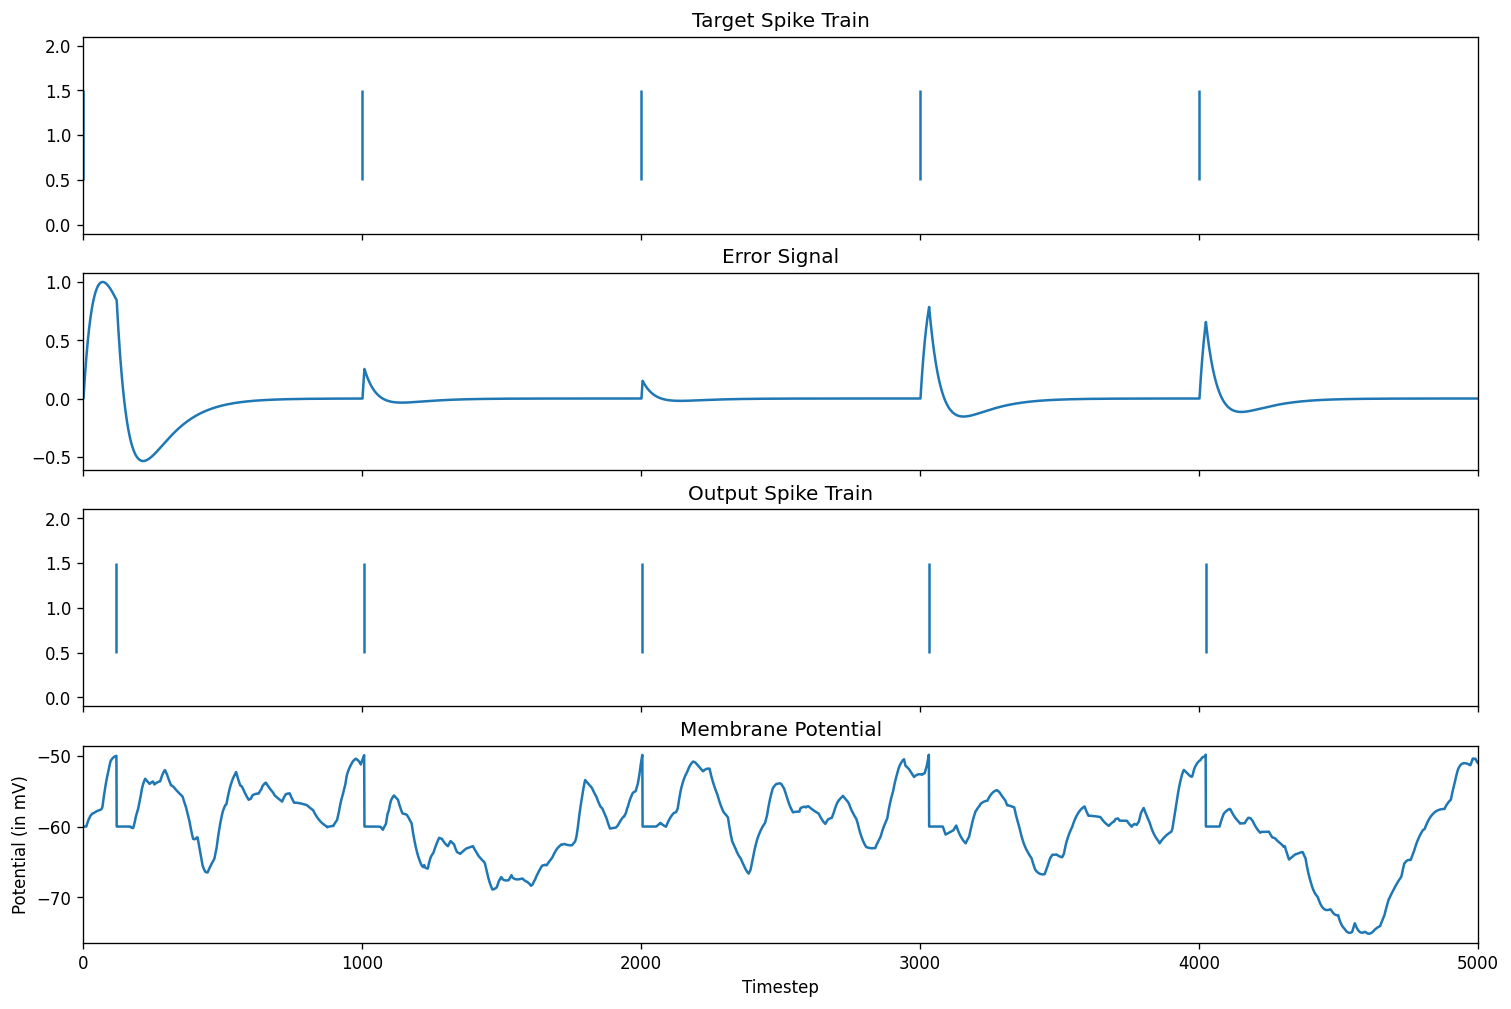

In [ ]:
plot_neuron_dynamics(mem_rec, spk_rec, error_rec, target)
plt.savefig(f"{images_dir}/after 100 epochs.png")

In [ ]:
counter = 100
for i in range(100):
  counter += 1
  print("Iteration:", counter)
  mem_rec, spk_rec, error_rec, eligibility_rec, pre_trace_rec = run_single_neuron(input_trains, weights,
                                                                                  target, args)
 # loss = van_rossum_loss(spk_rec, target, args)
 # print("Loss = ", loss)
  norm_loss = van_rossum_loss2(spk_rec, target, args)
  print("Normalized Loss =", norm_loss)
  loss_rec.append(norm_loss)
  # normalizing the eligibility trace:
 # print("Eligibilty shape:", eligibility_rec.shape)
  norm_factor, _ = torch.max(torch.abs(eligibility_rec), dim=2) # take max along time dimension for each i-jth synapse
 # print("Eligibility Norm_factor shape:", norm_factor.shape)
  norm_factor = torch.unsqueeze(norm_factor, 2)
 # print("Normalization Factor for Eligibility:",norm_factor)
 # print("Eligibility Norm_factor shape after unsequeeze:", norm_factor.shape)
  eligibility_rec = eligibility_rec / norm_factor
 # print("Normalized Eligibility rec:", eligibility_rec)
  eligibility_rec[eligibility_rec != eligibility_rec] = 0
 # print(torch.max(eligibility_rec))
 # print("eligibility_rec shape:", eligibility_rec.shape)

  # normalizing the error signal:
  norm_factor = torch.max(torch.abs(error_rec))
  error_rec = error_rec / norm_factor
#  print("max error value:", torch.max(error_rec))
#  print("Post normalization Error rec:", error_rec)
 # print("Error Signal shape:", error_rec.shape)
  # Weight update
  weight_updates = torch.sum(error_rec * eligibility_rec, dim=2)
  #print(weight_updates.shape)
#  print("Weight Updates:", weight_updates.T)

  # per-parameter learning rate
  gamma = float(np.exp(-dt/args['tau_rms']))
 # print("Gamma =", gamma)
  g_ij2 = (error_rec * eligibility_rec)[:, :, -1]**2
#  print("g_ij2 =", g_ij2)
  v_ij = torch.max(gamma*v_ij, g_ij2)

  r_ij = r_0 / torch.sqrt(v_ij)
#  print("Per-parameter learning rates:", r_ij.T)
#  print("change in weights =", (r_ij*weight_updates).T)
  weights += r_ij * weight_updates

Iteration: 101
torch.Size([5000])
Normalized Loss = tensor(0.0080)
Iteration: 102
torch.Size([5000])
Normalized Loss = tensor(0.0125)
Iteration: 103
torch.Size([5000])
Normalized Loss = tensor(0.0111)
Iteration: 104
torch.Size([5000])
Normalized Loss = tensor(0.0113)
Iteration: 105
torch.Size([5000])
Normalized Loss = tensor(0.0120)
Iteration: 106
torch.Size([5000])
Normalized Loss = tensor(0.0115)
Iteration: 107
torch.Size([5000])
Normalized Loss = tensor(0.0123)
Iteration: 108
torch.Size([5000])
Normalized Loss = tensor(0.0122)
Iteration: 109
torch.Size([5000])
Normalized Loss = tensor(0.0087)
Iteration: 110
torch.Size([5000])
Normalized Loss = tensor(0.0103)
Iteration: 111
torch.Size([5000])
Normalized Loss = tensor(0.0066)
Iteration: 112
torch.Size([5000])
Normalized Loss = tensor(0.0143)
Iteration: 113
torch.Size([5000])
Normalized Loss = tensor(0.0114)
Iteration: 114
torch.Size([5000])
Normalized Loss = tensor(0.0301)
Iteration: 115
torch.Size([5000])
Normalized Loss = tensor(0.0

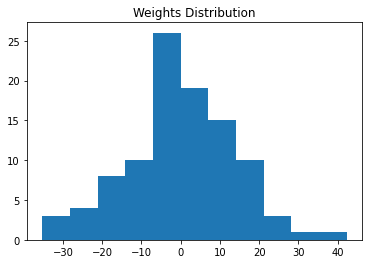

In [ ]:
weights[weights != weights] = 0
plot_weight_distribution(weights)
#print(weights)
#plot_neuron_dynamics(mem_rec, spk_rec, error_rec, target)

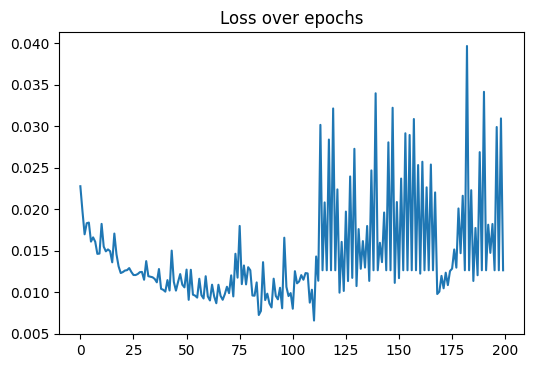

In [ ]:
plt.figure(dpi=100)
plt.plot(loss_rec)
plt.title("Loss over epochs")
plt.savefig(f'{images_dir}\loss over 200 epochs.png')